#   Segmentation with MedSAM2
Use MedSAM2 to segment a stack of OCT images.

In [ ]:
# @title Run this cell first, then click "Restart session" when prompted.
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.0 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=c89f6a7370b2b2a77dc7c0f6a3c96cb6113607a8adcc87d134b501fb984bdaf5
  Stored in directory: /root/.cache/pip/wheels/1a/97/32/461f837398029ad76911109f07047fde1d7b661a147c7c56d1
Successfully built antlr4-python3-runtime


In [ ]:
# @title Other installations
!pip install SimpleITK
!pip install roboflow
!pip install iopath
!git clone https://github.com/bowang-lab/MedSAM2.git
!pip3 install torch torchvision
%cd MedSAM2
!sh download.sh

Cloning into 'MedSAM2'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 206 (delta 67), reused 156 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (206/206), 1.25 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (67/67), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

## Load Roboflow data

In [ ]:
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
from roboflow import Roboflow

# LOAD ROBOFLOW DATA

API_KEYproject = rf.workspace("yolab-kmmfx").project("vol1_2")
version = project.version(2)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to vol1_2-2 in coco-segmentation:: 100%|██████████| 181/181 [00:00<00:00, 4374.56it/s]


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor
import torch
import json

# helper functions
DAVIS_PALETTE = b"\x00\x00\x00\x80\x00\x00\x00\x80\x00\x80\x80\x00\x00\x00\x80\x80\x00\x80\x00\x80\x80\x80\x80\x80@\x00\x00\xc0\x00\x00@\x80\x00\xc0\x80\x00@\x00\x80\xc0\x00\x80@\x80\x80\xc0\x80\x80\x00@\x00\x80@\x00\x00\xc0\x00\x80\xc0\x00\x00@\x80\x80@\x80\x00\xc0\x80\x80\xc0\x80@@\x00\xc0@\x00@\xc0\x00\xc0\xc0\x00@@\x80\xc0@\x80@\xc0\x80\xc0\xc0\x80\x00\x00@\x80\x00@\x00\x80@\x80\x80@\x00\x00\xc0\x80\x00\xc0\x00\x80\xc0\x80\x80\xc0@\x00@\xc0\x00@@\x80@\xc0\x80@@\x00\xc0\xc0\x00\xc0@\x80\xc0\xc0\x80\xc0\x00@@\x80@@\x00\xc0@\x80\xc0@\x00@\xc0\x80@\xc0\x00\xc0\xc0\x80\xc0\xc0@@@\xc0@@@\xc0@\xc0\xc0@@@\xc0\xc0@\xc0@\xc0\xc0\xc0\xc0\xc0 \x00\x00\xa0\x00\x00 \x80\x00\xa0\x80\x00 \x00\x80\xa0\x00\x80 \x80\x80\xa0\x80\x80`\x00\x00\xe0\x00\x00`\x80\x00\xe0\x80\x00`\x00\x80\xe0\x00\x80`\x80\x80\xe0\x80\x80 @\x00\xa0@\x00 \xc0\x00\xa0\xc0\x00 @\x80\xa0@\x80 \xc0\x80\xa0\xc0\x80`@\x00\xe0@\x00`\xc0\x00\xe0\xc0\x00`@\x80\xe0@\x80`\xc0\x80\xe0\xc0\x80 \x00@\xa0\x00@ \x80@\xa0\x80@ \x00\xc0\xa0\x00\xc0 \x80\xc0\xa0\x80\xc0`\x00@\xe0\x00@`\x80@\xe0\x80@`\x00\xc0\xe0\x00\xc0`\x80\xc0\xe0\x80\xc0 @@\xa0@@ \xc0@\xa0\xc0@ @\xc0\xa0@\xc0 \xc0\xc0\xa0\xc0\xc0`@@\xe0@@`\xc0@\xe0\xc0@`@\xc0\xe0@\xc0`\xc0\xc0\xe0\xc0\xc0\x00 \x00\x80 \x00\x00\xa0\x00\x80\xa0\x00\x00 \x80\x80 \x80\x00\xa0\x80\x80\xa0\x80@ \x00\xc0 \x00@\xa0\x00\xc0\xa0\x00@ \x80\xc0 \x80@\xa0\x80\xc0\xa0\x80\x00`\x00\x80`\x00\x00\xe0\x00\x80\xe0\x00\x00`\x80\x80`\x80\x00\xe0\x80\x80\xe0\x80@`\x00\xc0`\x00@\xe0\x00\xc0\xe0\x00@`\x80\xc0`\x80@\xe0\x80\xc0\xe0\x80\x00 @\x80 @\x00\xa0@\x80\xa0@\x00 \xc0\x80 \xc0\x00\xa0\xc0\x80\xa0\xc0@ @\xc0 @@\xa0@\xc0\xa0@@ \xc0\xc0 \xc0@\xa0\xc0\xc0\xa0\xc0\x00`@\x80`@\x00\xe0@\x80\xe0@\x00`\xc0\x80`\xc0\x00\xe0\xc0\x80\xe0\xc0@`@\xc0`@@\xe0@\xc0\xe0@@`\xc0\xc0`\xc0@\xe0\xc0\xc0\xe0\xc0  \x00\xa0 \x00 \xa0\x00\xa0\xa0\x00  \x80\xa0 \x80 \xa0\x80\xa0\xa0\x80` \x00\xe0 \x00`\xa0\x00\xe0\xa0\x00` \x80\xe0 \x80`\xa0\x80\xe0\xa0\x80 `\x00\xa0`\x00 \xe0\x00\xa0\xe0\x00 `\x80\xa0`\x80 \xe0\x80\xa0\xe0\x80``\x00\xe0`\x00`\xe0\x00\xe0\xe0\x00``\x80\xe0`\x80`\xe0\x80\xe0\xe0\x80  @\xa0 @ \xa0@\xa0\xa0@  \xc0\xa0 \xc0 \xa0\xc0\xa0\xa0\xc0` @\xe0 @`\xa0@\xe0\xa0@` \xc0\xe0 \xc0`\xa0\xc0\xe0\xa0\xc0 `@\xa0`@ \xe0@\xa0\xe0@ `\xc0\xa0`\xc0 \xe0\xc0\xa0\xe0\xc0``@\xe0`@`\xe0@\xe0\xe0@``\xc0\xe0`\xc0`\xe0\xc0\xe0\xe0\xc0"

def load_ann_png(path):
    """Load a PNG file as a mask and its palette."""
    mask = Image.open(path)
    palette = mask.getpalette()
    mask = np.array(mask).astype(np.uint8)
    return mask, palette

def get_per_obj_mask(mask):
    """Split a mask into per-object masks."""
    object_ids = np.unique(mask)
    object_ids = object_ids[object_ids > 0].tolist()
    per_obj_mask = {object_id: (mask == object_id) for object_id in object_ids}
    return per_obj_mask

def put_per_obj_mask(per_obj_mask, height, width):
    """Combine per-object masks into a single mask."""
    mask = np.zeros((height, width), dtype=np.uint8)
    object_ids = sorted(per_obj_mask)[::-1]
    for object_id in object_ids:
        object_mask = per_obj_mask[object_id]
        object_mask = object_mask.reshape(height, width)
        mask[object_mask] = object_id
    return mask

def load_masks_from_dir(input_mask_path):
    input_mask, input_palette = load_ann_png(input_mask_path)
    per_obj_input_mask = get_per_obj_mask(input_mask)

    return per_obj_input_mask, input_palette

def save_predictions_to_dir(
    output_mask_dir,
    video_name,
    frame_name,
    per_obj_output_mask,
    height,
    width,
):
    """Save masks to a directory as PNG files."""
    os.makedirs(os.path.join(output_mask_dir, video_name), exist_ok=True)

    output_mask = put_per_obj_mask(per_obj_output_mask, height, width)
    output_mask_path = os.path.join(
        output_mask_dir, video_name, f"{frame_name}.png"
    )
    assert output_mask.dtype == np.uint8
    assert output_mask.ndim == 2
    output_mask = Image.fromarray(output_mask)
    output_mask.save(output_mask_path)

def create_overlay(img_path, palette, mask_path=None, mask_img=None):
    """Create an overlay of an image and a mask with only non-black pixels blended."""
    img = Image.open(img_path).convert("RGB")
    if mask_img is not None:
        mask = mask_img
    elif mask_path:
        mask = Image.open(mask_path)

    # Apply palette and convert to RGB for color visualization
    mask.putpalette(palette)
    mask_rgb = mask.convert("RGB").resize(img.size, Image.NEAREST)

    # Convert to NumPy for pixel-wise blending
    img_np = np.array(img)
    mask_np = np.array(mask_rgb)

    # Identify non-black pixels in the mask (anything not [0,0,0])
    non_black = np.any(mask_np != [0, 0, 0], axis=-1)

    # Blend only non-black pixels
    overlay = img_np.copy()
    alpha = 0.5
    overlay[non_black] = ((1 - alpha) * img_np[non_black] + alpha * mask_np[non_black]).astype(np.uint8)

    return Image.fromarray(overlay)


In [ ]:
# @title CLAHE normalize images

def save_clahe_images(input_path, clahe_path):

    # Create output folder if it doesn't exist
    os.makedirs(clahe_path, exist_ok=True)

    for fn in os.listdir(input_path):
        if fn.lower().endswith('.jpg'):
            img = os.path.join(input_path, fn)

            output_path = os.path.join(clahe_path, fn)

            # Read the image
            image = cv2.imread(img)

            # Convert to LAB color space
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)

            # Apply CLAHE to the L-channel
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l_clahe = clahe.apply(l)

            # Merge the channels and convert back to BGR
            lab_clahe = cv2.merge((l_clahe, a, b))
            image_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

            # Save the result
            cv2.imwrite(output_path, image_clahe)

            # print(f"CLAHE normalized image saved to: {output_path}")


# save_clahe_images(input_path, clahe_path)

# # Visualize before and after

# # Select specific indices
# indices = [1, 10, 20, 30, 40]
# orig_files = sorted(os.listdir(input_path))
# normalized_files = sorted(os.listdir(clahe_path))

# # Select the files at those indices
# orig = [orig_files[i] for i in indices]
# normalized = [normalized_files[i] for i in indices]

# # Plot
# plt.figure(figsize=(12, 10))
# for idx, (ofn, nfn) in enumerate(zip(orig, normalized)):
#     # Read images
#     orig_img = cv2.imread(os.path.join(input_path, ofn))
#     norm_img = cv2.imread(os.path.join(clahe_path, nfn))

#     # Convert BGR to RGB for plotting
#     orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
#     norm_img = cv2.cvtColor(norm_img, cv2.COLOR_BGR2RGB)

#     # Plot original
#     plt.subplot(len(indices), 2, 2*idx + 1)
#     plt.imshow(orig_img)
#     plt.title(f'Original')
#     plt.axis('off')

#     # Plot normalized
#     plt.subplot(len(indices), 2, 2*idx + 2)
#     plt.imshow(norm_img)
#     plt.title(f'CLAHE')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:
# @title Convert COCO annotations to mask image
def create_mask_image(initial_mask_path, init_mask_idx, class_to_detect):
    """ class_to_detect: bv or lnf """

    first_frame_name = frame_names[init_mask_idx] + ".jpg"

    # print(first_frame_name)

    os.makedirs(os.path.dirname(initial_mask_path), exist_ok=True)

    with open(COCO_PATH, 'r') as f:
        coco = json.load(f)

    image_id_map = {img["file_name"]: img["id"] for img in coco["images"]}
    image_info_map = {img["id"]: img for img in coco["images"]}
    first_image_id = image_id_map[first_frame_name]

    from collections import defaultdict
    annotations_per_image = defaultdict(list)
    for ann in coco["annotations"]:
        annotations_per_image[ann["image_id"]].append(ann)

    file_name = first_frame_name
    if file_name not in image_id_map:
        print(f"Skipping frame {file_name}, not in COCO annotations.")

    image_id = image_id_map[file_name]
    image_info = image_info_map[image_id]
    height, width = image_info["height"], image_info["width"]

    # Create blank mask
    mask = np.zeros((height, width), dtype=np.uint8)

    obj_id = 200
    for ann in annotations_per_image[image_id]:
        if ann.get("iscrowd", 0):
            rle = mask_utils.frPyObjects([ann["segmentation"]], height, width)
            m = mask_utils.decode(rle[0])
        else:
            rle = mask_utils.frPyObjects(ann["segmentation"], height, width)
            m = mask_utils.decode(rle)
            if len(m.shape) == 3:
                m = np.any(m, axis=2).astype(np.uint8)

        # Assign unique ID per class
        if class_to_detect == 'lnf':
          if ann["category_id"] == 2: # LNF
              mask[m.astype(bool)] = obj_id

        elif class_to_detect == 'bv_2':
          if ann["category_id"] == 1: # BV
              mask[m.astype(bool)] = obj_id

        elif class_to_detect == 'roi':
          if ann["category_id"] == 3: # tumor
              mask[m.astype(bool)] = obj_id

    Image.fromarray(mask).save(initial_mask_path)
    plt.imshow(mask)
    plt.show()

    # print(f"Saved mask for {first_frame_name} with {obj_id - 1} object(s)")
    print(f"Unique values in mask: {np.unique(mask)}")

# create_mask_image(initial_mask_path, init_mask_idx)

## Prepare Inference and Add Initial Mask Prompt

In [ ]:

def add_input_masks_from_keyframe(init_mask_idx, initial_mask_path):
    """ init_mask_idx: index of the mask file """

    # Add input masks to MedSAM2 inference state before propagation
    object_ids_set = None
    input_frame_idx = init_mask_idx  # use first frame as mask input
    try:
        per_obj_input_mask, input_palette = load_masks_from_dir(input_mask_path=initial_mask_path)
    except FileNotFoundError as e:
        raise RuntimeError(
            f"In {VIDEO_NAME=}, failed to load input mask for frame {input_frame_idx=}. "
            "Please add the `--track_object_appearing_later_in_video` flag "
            "for VOS datasets that don't have all objects to track appearing "
            "in the first frame (such as LVOS or YouTube-VOS)."
        ) from e

    # get the list of object ids to track from the first input frame
    if object_ids_set is None:
        object_ids_set = set(per_obj_input_mask)
    for object_id, object_mask in per_obj_input_mask.items():
        # check and make sure no new object ids appear only in later frames
        if object_id not in object_ids_set:
            # raise RuntimeError(
            #     f"In {VIDEO_NAME=}, got a new {object_id=} appearing only in a "
            #     f"later {input_frame_idx=} (but not appearing in the first frame). "
            #     "Please add the `--track_object_appearing_later_in_video` flag "
            #     "for VOS datasets that don't have all objects to track appearing "
            #     "in the first frame (such as LVOS or YouTube-VOS)."
            # )
            print(f"WARNING: in {VIDEO_NAME=}, got no object ids on {input_frame_idx=}.")
        predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=input_frame_idx,
            obj_id=object_id,
            mask=object_mask,
                )

    # check and make sure we have at least one object to track
    if object_ids_set is None or len(object_ids_set) == 0:
        # raise RuntimeError(
        #     f"In {VIDEO_NAME=}, got no object ids on {input_frame_idx=}. "
        #     "Please add the `--track_object_appearing_later_in_video` flag "
        #     "for VOS datasets that don't have all objects to track appearing "
        #     "in the first frame (such as LVOS or YouTube-VOS)."
        # )
        print(f"WARNING: in {VIDEO_NAME=}, got no object ids on {input_frame_idx=}.")

    return object_ids_set

# add_input_masks_from_keyframe(init_mask_idx)

## Run Inference

In [ ]:
def run_bidirectional_inference_between_pairs(predictor, inference_state, pair_indices, class_to_detect, forwards=True, backwards=True):
    start_idx, end_idx = pair_indices

    video_segments_f = {}
    video_segments_b = {}
    video_logits_f = {}
    video_logits_b = {}

    inference_state = predictor.init_state(
    video_path=os.path.join(VIDEO_DIR, VIDEO_NAME), async_loading_frames=False)

    height = inference_state["video_height"]
    width = inference_state["video_width"]

    print(f"\n=== FORWARD from frame {start_idx} to {end_idx} ===")

    create_mask_image(f"vol1_2-2/output_masks_{class_to_detect}/" + frame_names[start_idx] + ".png", start_idx, class_to_detect)
    per_obj_input_mask, input_palette = load_masks_from_dir(f"vol1_2-2/output_masks_{class_to_detect}/" + frame_names[start_idx] + ".png")

    for object_id, object_mask in per_obj_input_mask.items():
        # print(object_id)
        predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=start_idx,
            obj_id=object_id,
            mask=object_mask,
                )

    # if no objects, don't run in this direction
    if len(per_obj_input_mask) == 0:
        forwards = False

    if forwards:

        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=start_idx,
            max_frame_num_to_track=end_idx-start_idx):
            # Get binary masks
            per_obj_output_mask = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

            # Save segmentation
            video_segments_f[out_frame_idx] = per_obj_output_mask

            # Store logits
            video_logits_f[out_frame_idx] = {
                out_obj_id: out_mask_logits[i].cpu()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

            # Save masks to disk
            save_predictions_to_dir(
                output_mask_dir=FORWARD_OUTDIR,
                video_name=VIDEO_NAME,
                frame_name=frame_names[out_frame_idx],
                per_obj_output_mask=per_obj_output_mask,
                height=height,
                width=width,
            )

            # Feed each predicted mask as a prompt for the next frame
            next_frame_idx = out_frame_idx + 1
            # print("curr:", out_frame_idx, "next:", next_frame_idx)
            # if next_frame_idx < end_idx:
              # print("\t", frame_names[next_frame_idx])
            if next_frame_idx < end_idx:
                for obj_id, mask in per_obj_output_mask.items():
                    if mask is not None and np.any(mask):
                        predictor.add_new_mask(
                            inference_state=inference_state,
                            frame_idx=next_frame_idx,
                            obj_id=obj_id,
                            mask=mask.squeeze(),
                        )



    # Reinitialize for backwards pass
    inference_state = predictor.init_state(
    video_path=os.path.join(VIDEO_DIR, VIDEO_NAME), async_loading_frames=False)

    print(f"\n=== BACKWARD from frame {end_idx} to {start_idx} ===")

    create_mask_image(f"vol1_2-2/output_masks_{class_to_detect}/" + frame_names[end_idx] + ".png", end_idx, class_to_detect)
    per_obj_input_mask, input_palette = load_masks_from_dir(f"vol1_2-2/output_masks_{class_to_detect}/" + frame_names[end_idx] + ".png")
    for object_id, object_mask in per_obj_input_mask.items():
        predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=end_idx,
            obj_id=object_id,
            mask=object_mask.squeeze(),
            )

    # if no objects, don't run in this direction
    if len(per_obj_input_mask) == 0:
        backwards = False

    if backwards:

        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=end_idx,
            max_frame_num_to_track=end_idx-start_idx, reverse=True):
            # Get binary masks
            per_obj_output_mask = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

            # Save segmentation
            video_segments_b[out_frame_idx] = per_obj_output_mask

            # Store logits
            video_logits_b[out_frame_idx] = {
                out_obj_id: out_mask_logits[i].cpu()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

            height = inference_state["video_height"]
            width = inference_state["video_width"]

            # Save masks to disk
            save_predictions_to_dir(
                output_mask_dir=BACKWARD_OUTDIR,
                video_name=VIDEO_NAME,
                frame_name=frame_names[out_frame_idx],
                per_obj_output_mask=per_obj_output_mask,
                height=height,
                width=width,
            )

            # Feed each predicted mask as a prompt for the next frame
            next_frame_idx = out_frame_idx - 1
            # print("curr:", out_frame_idx, "next:", next_frame_idx)
            # print("\t", frame_names[next_frame_idx])

            if next_frame_idx > start_idx:
                for obj_id, mask in per_obj_output_mask.items():
                    if mask is not None and np.any(mask):
                        predictor.add_new_mask(
                            inference_state=inference_state,
                            frame_idx=next_frame_idx,
                            obj_id=obj_id,
                            mask=mask.squeeze(),
                        )
    return video_segments_f, video_segments_b, video_logits_f, video_logits_b, input_palette

# video_segments_f, video_segments_b, video_logits_f, video_logits_b, input_palette = run_bidirectional_inference_between_pairs(predictor, inference_state, keyframe_indices)

In [ ]:
# @title Reconcile F/B Masks
from torch.nn.functional import sigmoid

def merge_bidirectional_masks(keyframe_indices, video_logits_f, video_logits_b, thresh=0.5):

    fused_masks = {}

    for t in range(keyframe_indices[0], keyframe_indices[1] + 1):
        if t in video_logits_f and t in video_logits_b:
            # print(f"Merging masks for frame {t}")
            frame_logits_f = video_logits_f[t]
            frame_logits_b = video_logits_b[t]
            fused_masks[t] = {}

            for obj_id in frame_logits_f.keys():
                if obj_id in frame_logits_b:
                    logit_f = frame_logits_f[obj_id]
                    logit_b = frame_logits_b[obj_id]

                    # Distance-weighted fusion: favor closer keyframe
                    alpha = (keyframe_indices[1] - t) / (keyframe_indices[1] - keyframe_indices[0])
                    fused_logit = alpha * logit_f + (1 - alpha) * logit_b

                    # Apply sigmoid to get probabilities
                    prob = sigmoid(fused_logit)

                    # Threshold to bool
                    mask = (prob > thresh).bool().numpy()

                    fused_masks[t][obj_id] = mask
        elif t in video_logits_f:
            print(f"Using forward masks for frame {t}")
            if t not in fused_masks:
                fused_masks[t] = {}
            for obj_id, logit in video_logits_f[t].items():
                fused_masks[t][obj_id] = (sigmoid(logit) > thresh).bool().numpy()
        elif t in video_logits_b:
            print(f"Using backward masks for frame {t}")
            if t not in fused_masks:
                fused_masks[t] = {}
            for obj_id, logit in video_logits_b[t].items():
                fused_masks[t][obj_id] = (sigmoid(logit) > thresh).bool().numpy()
        else:
            print(f"No masks found for frame {t}")

    return fused_masks


Keyframe indices: [0, 4, 20, 46, 104, 115, 133, 136, 151, 174, 176]


Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 107.94it/s]


Evaluating pair:  [0, 4]


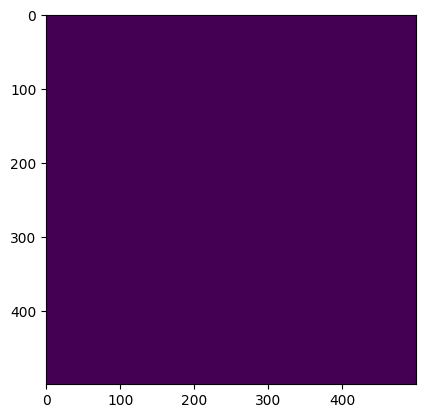

Unique values in mask: [0]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 109.16it/s]



=== FORWARD from frame 0 to 4 ===


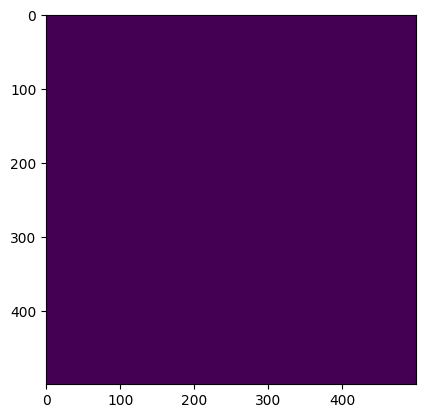

Unique values in mask: [0]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 110.82it/s]



=== BACKWARD from frame 4 to 0 ===


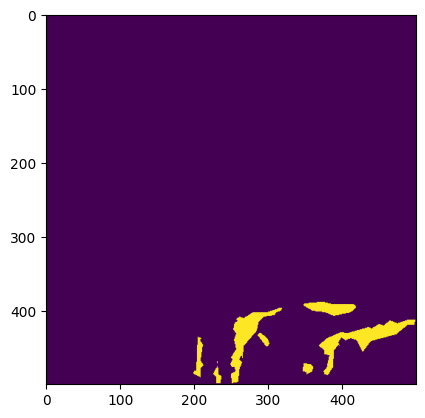

Unique values in mask: [  0 200]


Python version mismatch: module was compiled for Python 3.12, but the interpreter version is incompatible: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0].

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
propagate in video: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Using backward masks for frame 0
Using backward masks for frame 1
Using backward masks for frame 2
Using backward masks for frame 3
Using backward masks for frame 4


frame loading (JPEG): 100%|██████████| 177/177 [00:02<00:00, 76.18it/s] 


Evaluating pair:  [4, 20]


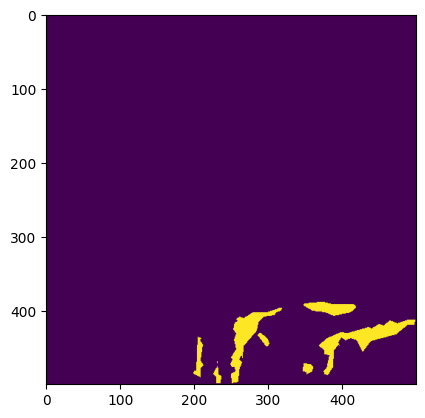

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 106.84it/s]



=== FORWARD from frame 4 to 20 ===


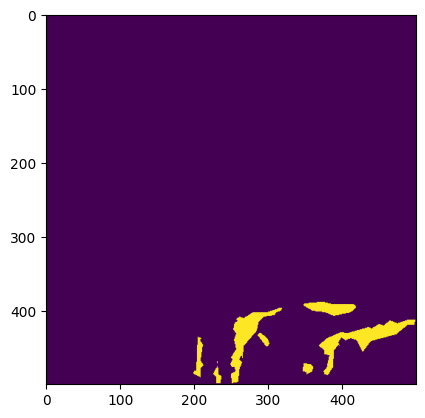

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 107.62it/s]



=== BACKWARD from frame 20 to 4 ===


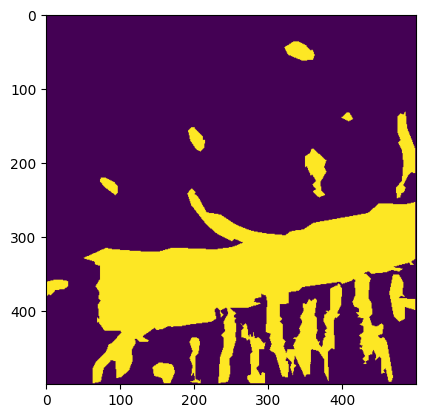

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 17/17 [00:01<00:00, 16.91it/s]


Merging masks for frame 4
Merging masks for frame 5
Merging masks for frame 6
Merging masks for frame 7
Merging masks for frame 8
Merging masks for frame 9
Merging masks for frame 10
Merging masks for frame 11
Merging masks for frame 12
Merging masks for frame 13
Merging masks for frame 14
Merging masks for frame 15
Merging masks for frame 16
Merging masks for frame 17
Merging masks for frame 18
Merging masks for frame 19
Merging masks for frame 20


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 102.41it/s]


Evaluating pair:  [20, 46]


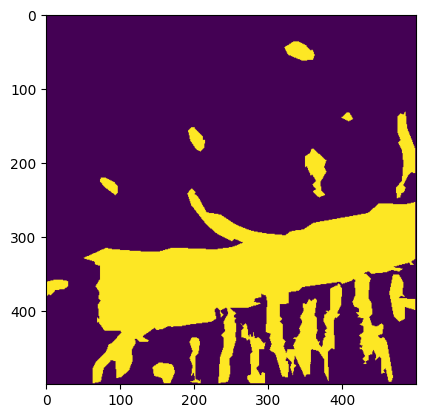

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:02<00:00, 82.21it/s] 



=== FORWARD from frame 20 to 46 ===


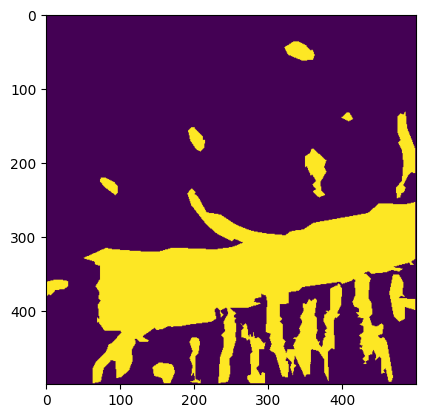

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 109.41it/s]



=== BACKWARD from frame 46 to 20 ===


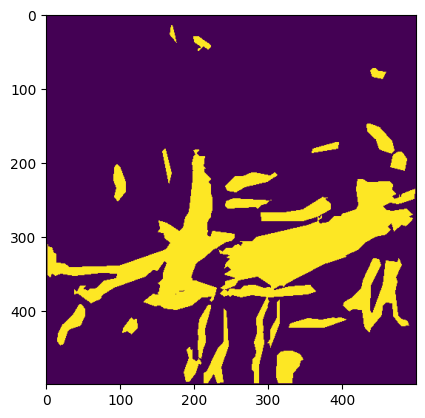

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 27/27 [00:01<00:00, 16.70it/s]


Merging masks for frame 20
Merging masks for frame 21
Merging masks for frame 22
Merging masks for frame 23
Merging masks for frame 24
Merging masks for frame 25
Merging masks for frame 26
Merging masks for frame 27
Merging masks for frame 28
Merging masks for frame 29
Merging masks for frame 30
Merging masks for frame 31
Merging masks for frame 32
Merging masks for frame 33
Merging masks for frame 34
Merging masks for frame 35
Merging masks for frame 36
Merging masks for frame 37
Merging masks for frame 38
Merging masks for frame 39
Merging masks for frame 40
Merging masks for frame 41
Merging masks for frame 42
Merging masks for frame 43
Merging masks for frame 44
Merging masks for frame 45
Merging masks for frame 46


frame loading (JPEG): 100%|██████████| 177/177 [00:02<00:00, 76.50it/s]


Evaluating pair:  [46, 104]


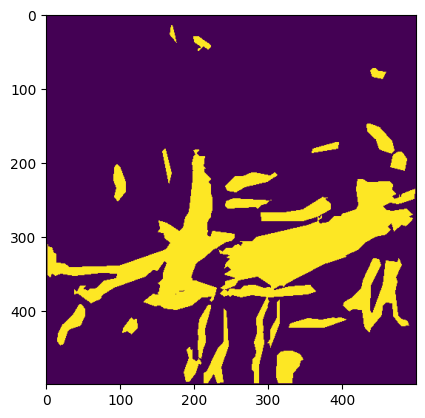

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:02<00:00, 83.77it/s] 



=== FORWARD from frame 46 to 104 ===


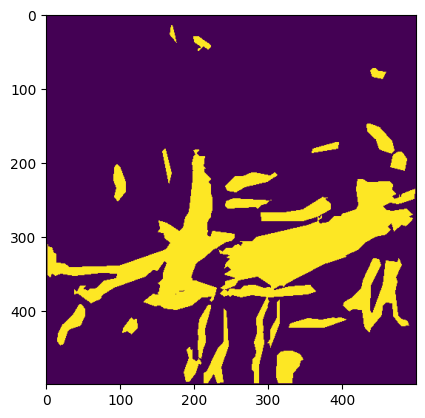

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 105.81it/s]



=== BACKWARD from frame 104 to 46 ===


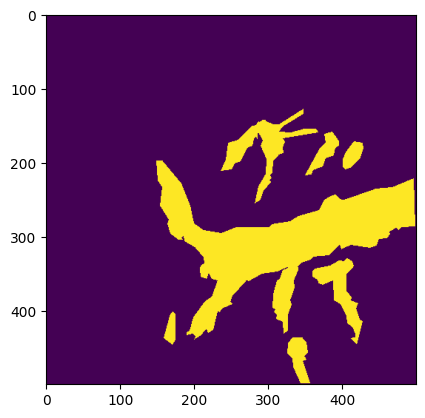

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 59/59 [00:03<00:00, 15.76it/s]


Merging masks for frame 46
Merging masks for frame 47
Merging masks for frame 48
Merging masks for frame 49
Merging masks for frame 50
Merging masks for frame 51
Merging masks for frame 52
Merging masks for frame 53
Merging masks for frame 54
Merging masks for frame 55
Merging masks for frame 56
Merging masks for frame 57
Merging masks for frame 58
Merging masks for frame 59
Merging masks for frame 60
Merging masks for frame 61
Merging masks for frame 62
Merging masks for frame 63
Merging masks for frame 64
Merging masks for frame 65
Merging masks for frame 66
Merging masks for frame 67
Merging masks for frame 68
Merging masks for frame 69
Merging masks for frame 70
Merging masks for frame 71
Merging masks for frame 72
Merging masks for frame 73
Merging masks for frame 74
Merging masks for frame 75
Merging masks for frame 76
Merging masks for frame 77
Merging masks for frame 78
Merging masks for frame 79
Merging masks for frame 80
Merging masks for frame 81
Merging masks for frame 82
M

frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 105.04it/s]


Evaluating pair:  [104, 115]


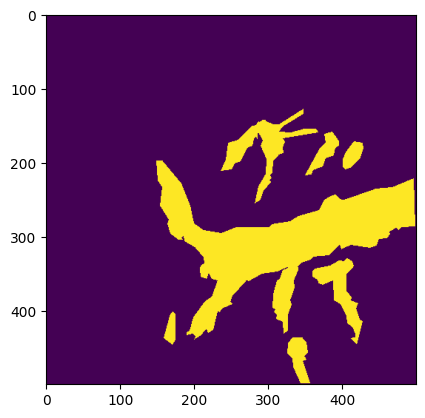

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 104.28it/s]



=== FORWARD from frame 104 to 115 ===


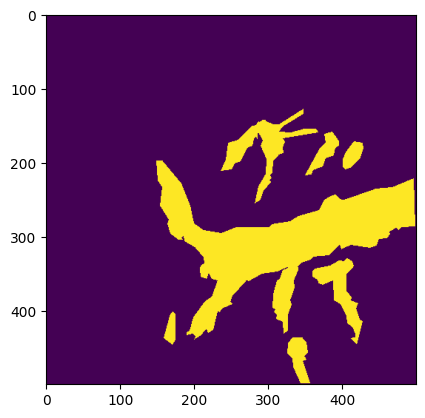

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 105.04it/s]



=== BACKWARD from frame 115 to 104 ===


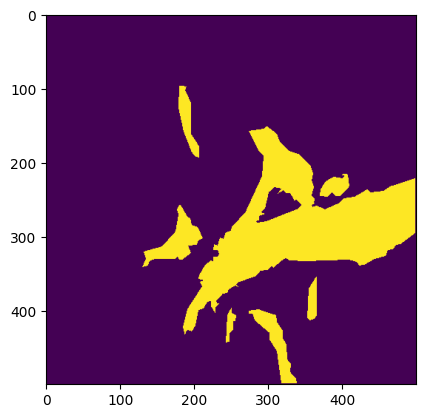

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 12/12 [00:00<00:00, 16.68it/s]


Merging masks for frame 104
Merging masks for frame 105
Merging masks for frame 106
Merging masks for frame 107
Merging masks for frame 108
Merging masks for frame 109
Merging masks for frame 110
Merging masks for frame 111
Merging masks for frame 112
Merging masks for frame 113
Merging masks for frame 114
Merging masks for frame 115


frame loading (JPEG): 100%|██████████| 177/177 [00:02<00:00, 75.61it/s]


Evaluating pair:  [115, 133]


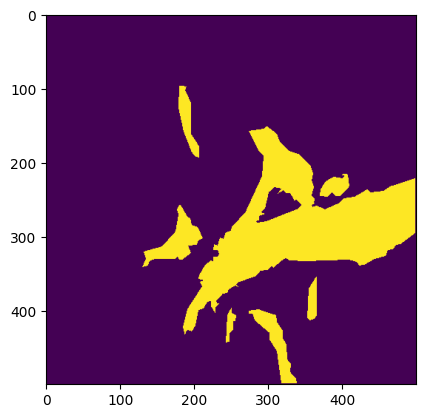

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 104.21it/s]



=== FORWARD from frame 115 to 133 ===


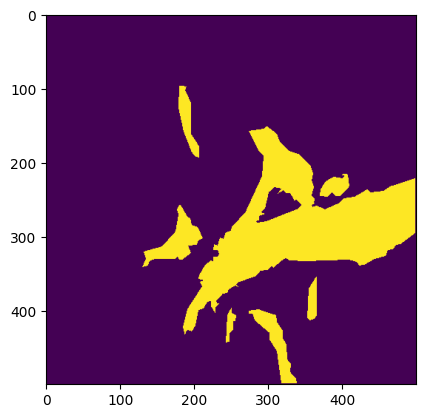

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 106.82it/s]



=== BACKWARD from frame 133 to 115 ===


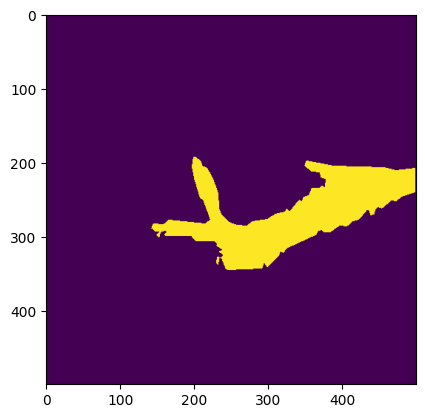

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 19/19 [00:01<00:00, 16.72it/s]


Merging masks for frame 115
Merging masks for frame 116
Merging masks for frame 117
Merging masks for frame 118
Merging masks for frame 119
Merging masks for frame 120
Merging masks for frame 121
Merging masks for frame 122
Merging masks for frame 123
Merging masks for frame 124
Merging masks for frame 125
Merging masks for frame 126
Merging masks for frame 127
Merging masks for frame 128
Merging masks for frame 129
Merging masks for frame 130
Merging masks for frame 131
Merging masks for frame 132
Merging masks for frame 133


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 104.91it/s]


Evaluating pair:  [133, 136]


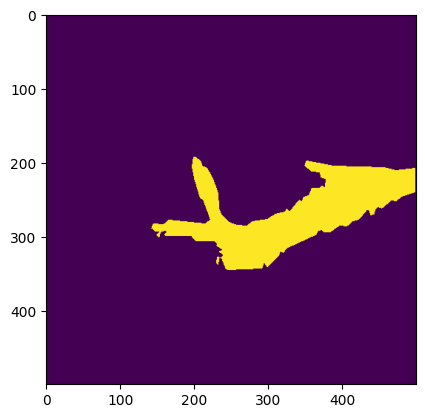

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:02<00:00, 70.22it/s]



=== FORWARD from frame 133 to 136 ===


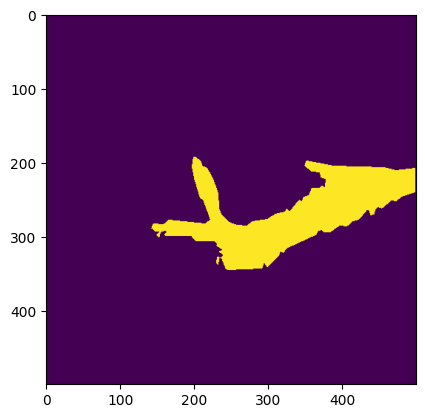

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 102.10it/s]



=== BACKWARD from frame 136 to 133 ===


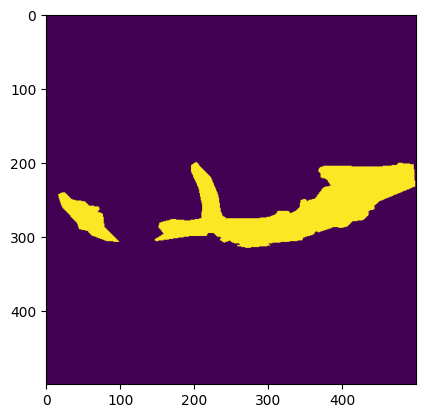

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 4/4 [00:00<00:00, 18.42it/s]


Merging masks for frame 133
Merging masks for frame 134
Merging masks for frame 135
Merging masks for frame 136


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 104.32it/s]


Evaluating pair:  [136, 151]


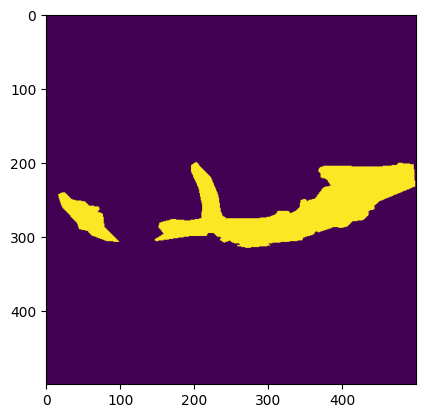

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 105.63it/s]



=== FORWARD from frame 136 to 151 ===


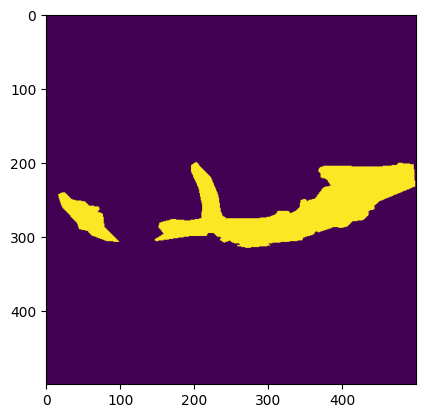

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:02<00:00, 67.61it/s]



=== BACKWARD from frame 151 to 136 ===


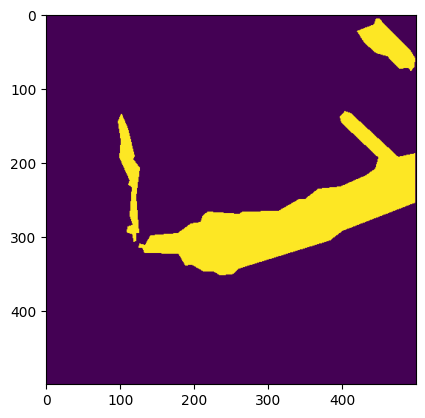

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 16/16 [00:00<00:00, 16.95it/s]


Merging masks for frame 136
Merging masks for frame 137
Merging masks for frame 138
Merging masks for frame 139
Merging masks for frame 140
Merging masks for frame 141
Merging masks for frame 142
Merging masks for frame 143
Merging masks for frame 144
Merging masks for frame 145
Merging masks for frame 146
Merging masks for frame 147
Merging masks for frame 148
Merging masks for frame 149
Merging masks for frame 150
Merging masks for frame 151


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 104.74it/s]


Evaluating pair:  [151, 174]


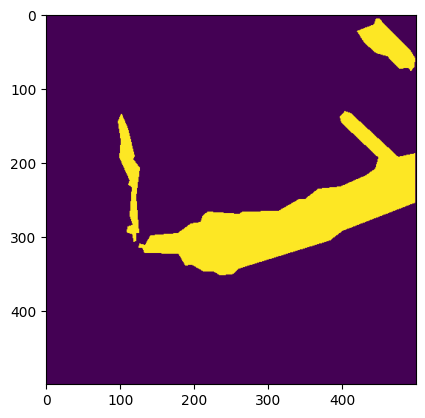

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 105.05it/s]



=== FORWARD from frame 151 to 174 ===


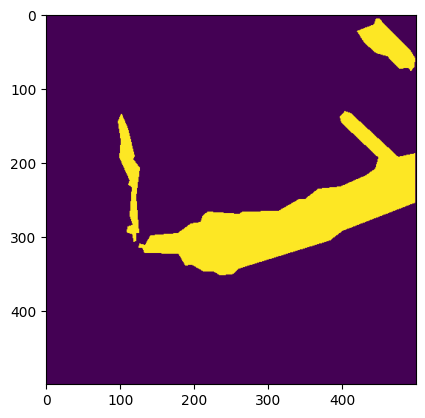

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 88.87it/s]



=== BACKWARD from frame 174 to 151 ===


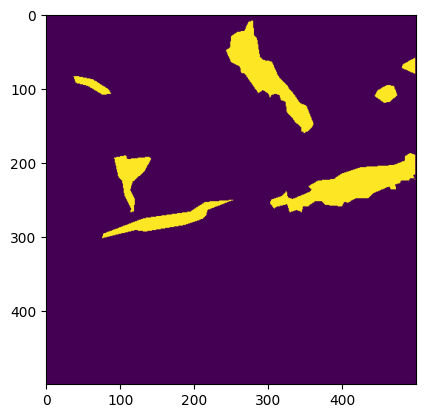

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 24/24 [00:01<00:00, 14.48it/s]


Merging masks for frame 151
Merging masks for frame 152
Merging masks for frame 153
Merging masks for frame 154
Merging masks for frame 155
Merging masks for frame 156
Merging masks for frame 157
Merging masks for frame 158
Merging masks for frame 159
Merging masks for frame 160
Merging masks for frame 161
Merging masks for frame 162
Merging masks for frame 163
Merging masks for frame 164
Merging masks for frame 165
Merging masks for frame 166
Merging masks for frame 167
Merging masks for frame 168
Merging masks for frame 169
Merging masks for frame 170
Merging masks for frame 171
Merging masks for frame 172
Merging masks for frame 173
Merging masks for frame 174


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 102.26it/s]


Evaluating pair:  [174, 176]


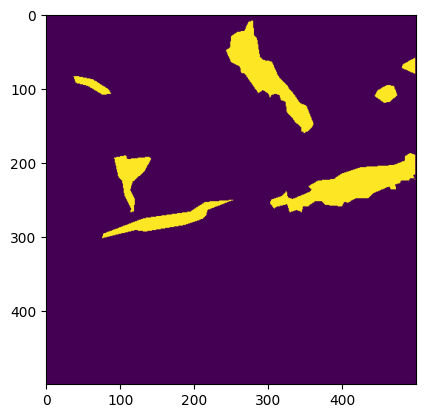

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 103.41it/s]



=== FORWARD from frame 174 to 176 ===


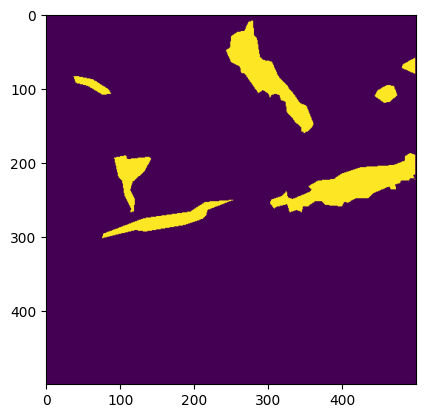

Unique values in mask: [  0 200]


frame loading (JPEG): 100%|██████████| 177/177 [00:01<00:00, 101.21it/s]



=== BACKWARD from frame 176 to 174 ===


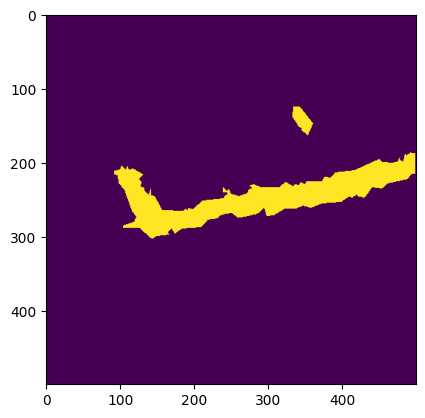

Unique values in mask: [  0 200]


propagate in video: 100%|██████████| 3/3 [00:00<00:00, 19.48it/s]

Merging masks for frame 174
Merging masks for frame 175
Merging masks for frame 176


In [ ]:
# @title Run model for series of keyframes

VIDEO_DIR = "vol1_2-2/clahe/"
VIDEO_NAME = ""
OUTPUT_DIR = "vol1_2-2/output/"
COCO_PATH = "vol1_2-2/test/_annotations.coco.json"

MODEL_CONFIG = "configs/sam2.1_hiera_t512.yaml"
MODEL_CHECKPOINT = "checkpoints/MedSAM2_latest.pt"

FORWARD_OUTDIR = "vol1_2-2/out_forwards/"
BACKWARD_OUTDIR = "vol1_2-2/out_backwards/"
os.makedirs(os.path.join(FORWARD_OUTDIR, VIDEO_NAME), exist_ok=True)
os.makedirs(os.path.join(BACKWARD_OUTDIR, VIDEO_NAME), exist_ok=True)

# CLAHE equalization
orig_images_path = 'vol1_2-2/test/'
clahe_path = 'vol1_2-2/clahe/'
save_clahe_images(orig_images_path, clahe_path)


# load the video frames
frame_names = [
        os.path.splitext(p)[0]
        for p in os.listdir(os.path.join(VIDEO_DIR, VIDEO_NAME))
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
frame_names = list(sorted(frame_names))

# Initialize keyframes
class_to_detect = "lnf" # "lnf" or "bv"
full_annotations_partial_file_names = ["0064", "0068","0084", "0110","0168", "0179", "0197", "0200", "0215","0238"]

# class_to_detect = "bv_2"
# full_annotations_partial_file_names = ["0064","0070", "0081", "0100", "0126", "0152", "0161", "0174", "0178", "0195", "0220", "0240"]

# class_to_detect = "roi"
# full_annotations_partial_file_names = ["0064","0115", "0122", "0139", "0160"]

keyframe_indices = {0, len(frame_names)-1}
for ann in full_annotations_partial_file_names:
    for i, name in enumerate(frame_names):
        if ann in name:
            keyframe_indices.add(i)

keyframe_indices = sorted(list(keyframe_indices))
print("Keyframe indices:", keyframe_indices)

for i in range(len(keyframe_indices)-1):

    # Initialize predictor
    predictor = build_sam2_video_predictor(
        config_file=MODEL_CONFIG,
        ckpt_path=MODEL_CHECKPOINT,
        apply_postprocessing=True,
        # hydra_overrides_extra=hydra_overrides_extra,
        vos_optimized=  True,
    )
    inference_state = predictor.init_state(video_path=os.path.join(VIDEO_DIR, VIDEO_NAME), async_loading_frames=False)
    # predictor.reset_state(inference_state)


    kf_pair = [keyframe_indices[i], keyframe_indices[i+1]]
    print("Evaluating pair: ", kf_pair)

    # print(len(frame_names), len(full_annotations_partial_file_names), full_annotations_partial_file_names[i])

    matching_frame_name = next((name for name in frame_names if full_annotations_partial_file_names[i] in name), None)
    initial_mask_path = f"vol1_2-2/output_masks_{class_to_detect}/{matching_frame_name}.png"

    # Create masks from COCO
    mask = create_mask_image(initial_mask_path, kf_pair[0], class_to_detect)
    add_input_masks_from_keyframe(kf_pair[0], initial_mask_path)

    video_segments_f, video_segments_b, video_logits_f, video_logits_b, input_palette = run_bidirectional_inference_between_pairs(predictor, inference_state, kf_pair, class_to_detect)

    fused_masks = merge_bidirectional_masks(kf_pair, video_logits_f, video_logits_b)

    height = inference_state["video_height"]
    width = inference_state["video_width"]

    for t, obj_masks in fused_masks.items():
            save_predictions_to_dir(
                output_mask_dir=f"vol1_2-2/merged_predictions_{class_to_detect}/",
                video_name=VIDEO_NAME,
                frame_name=frame_names[t],
                per_obj_output_mask=obj_masks,
                height=height,
                width=width,
            )


In [ ]:
import shutil
from google.colab import files

# Set the path of the folder you want to download
folder_path = f"vol1_2-2/merged_predictions_{class_to_detect}/"  # change this to your folder path
zip_path = f"/content/merged_predictions_{class_to_detect}.zip"

# Zip the folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

# Download the zip file
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Excluding y0064_png.rf.2c605addf59a1ba0c3832382c6af6825 for class 1


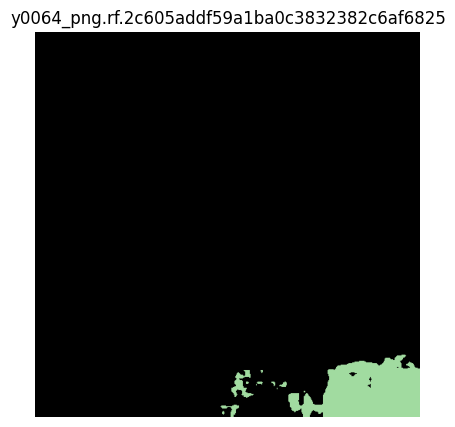

Excluding y0065_png.rf.f9416bab63457617606d6f09996827c3 for class 1


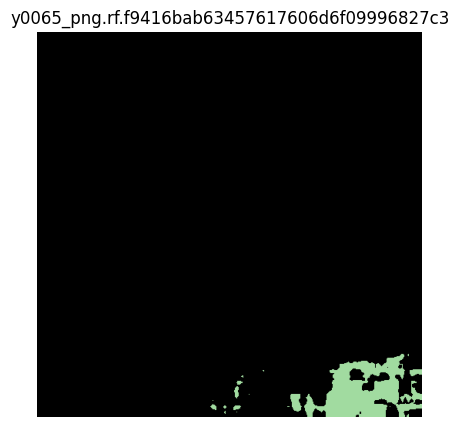

Excluding y0066_png.rf.46645401c462261d6ea9ba88ce2b0c6c for class 1


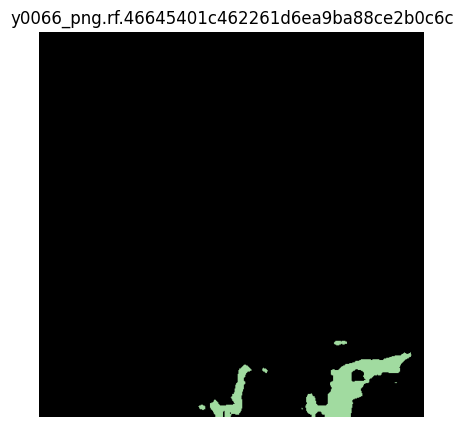

Excluding y0067_png.rf.fbfd9c2116065bb26c5c787e317afe63 for class 1


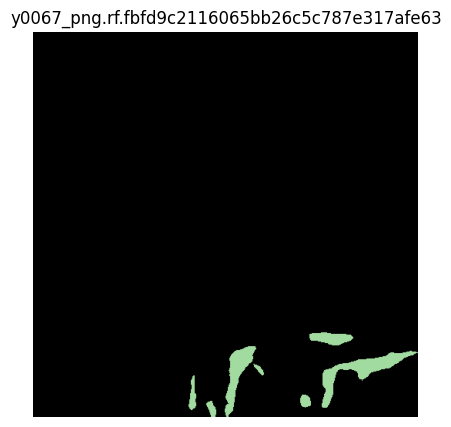

Excluding y0068_png.rf.7e699449acdc2221026609ab5be0a7b7 for class 1


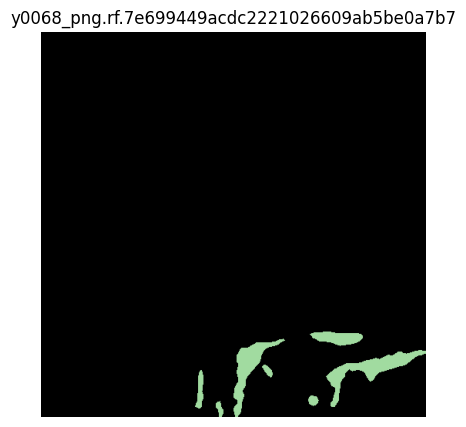

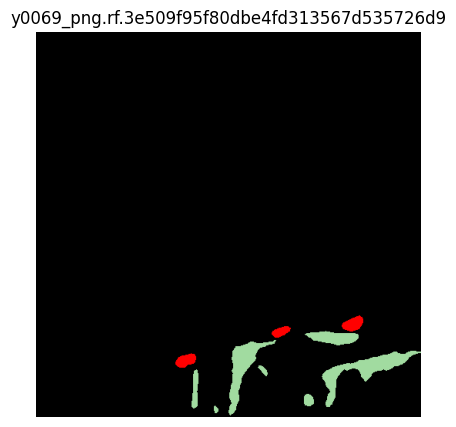

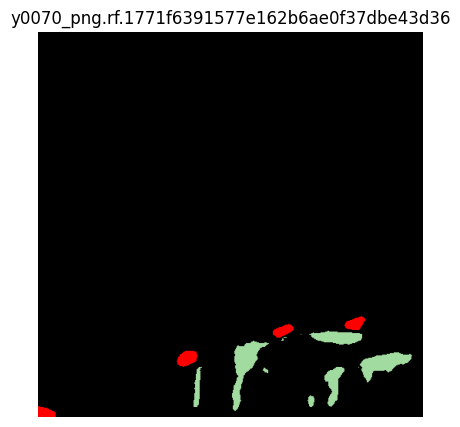

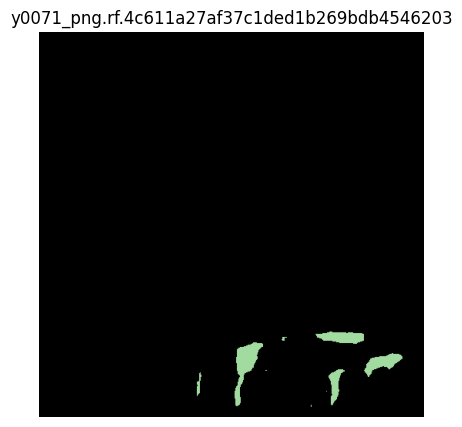

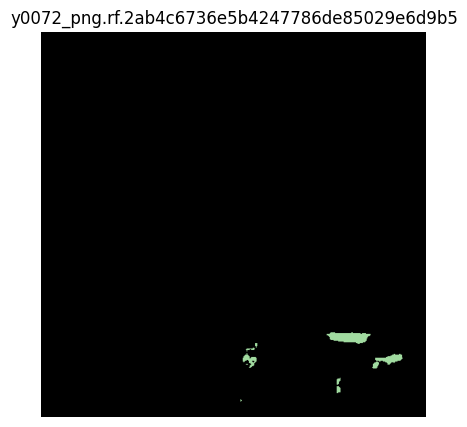

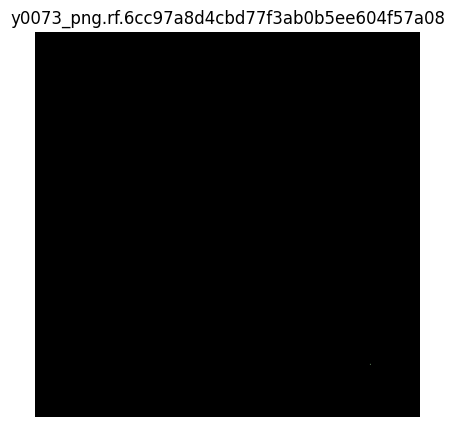

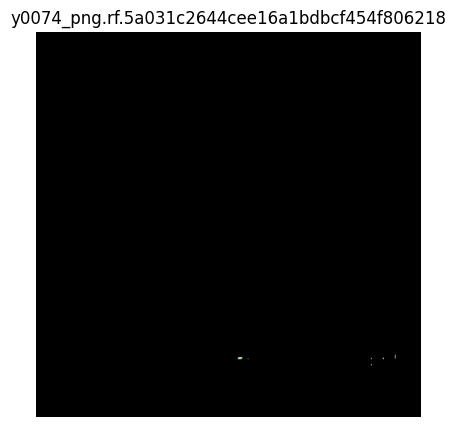

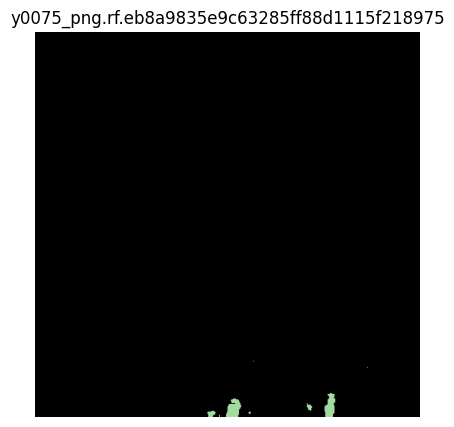

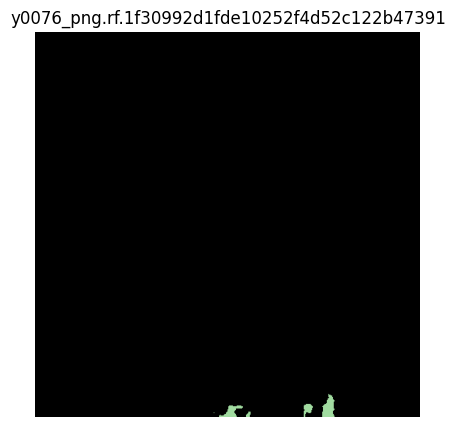

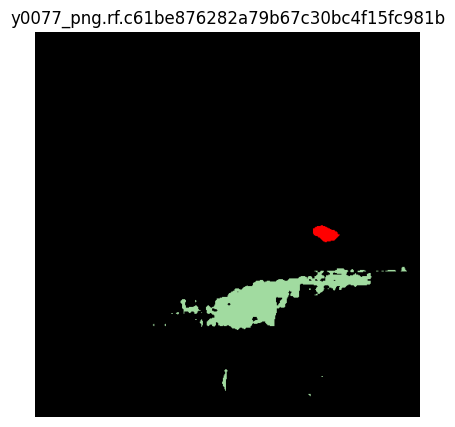

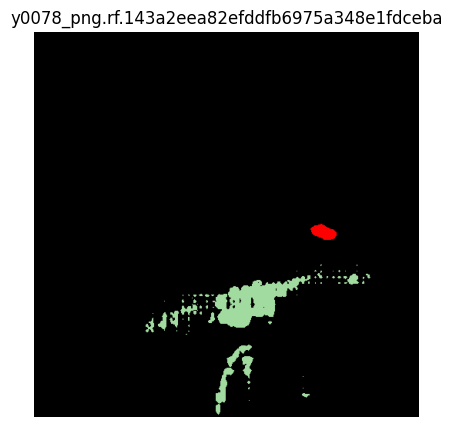

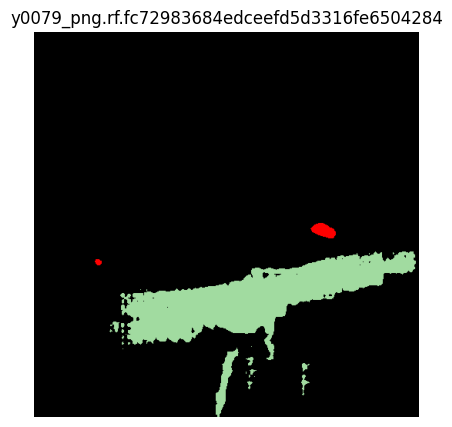

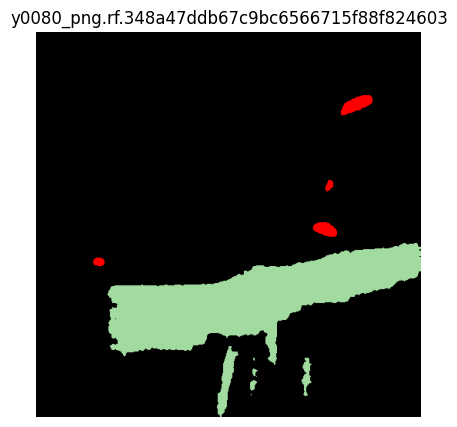

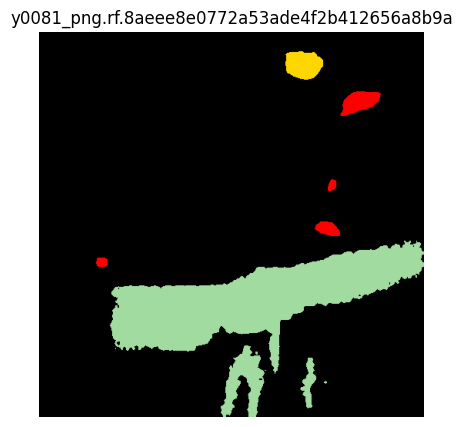

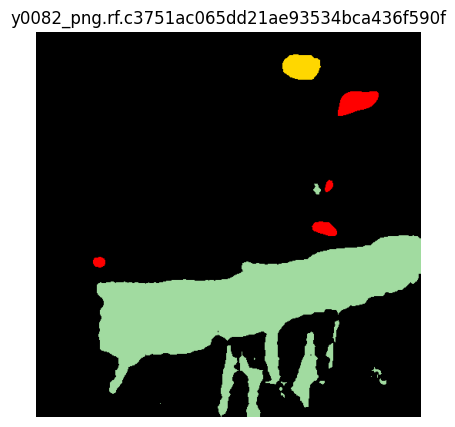

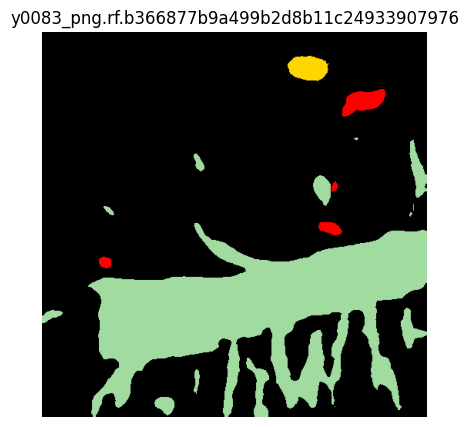

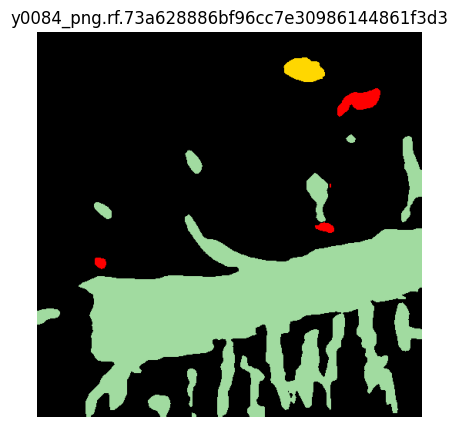

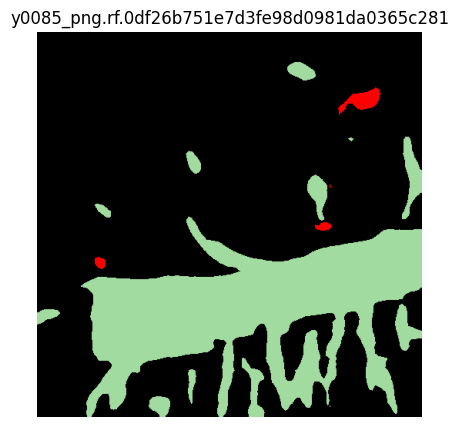

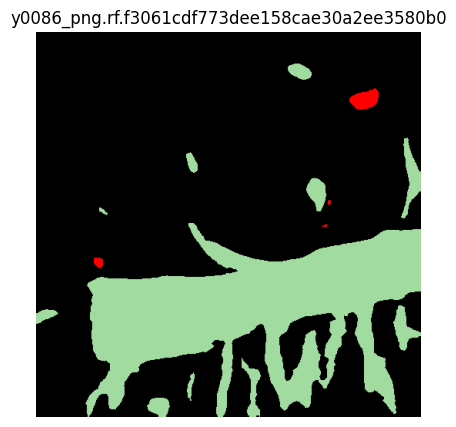

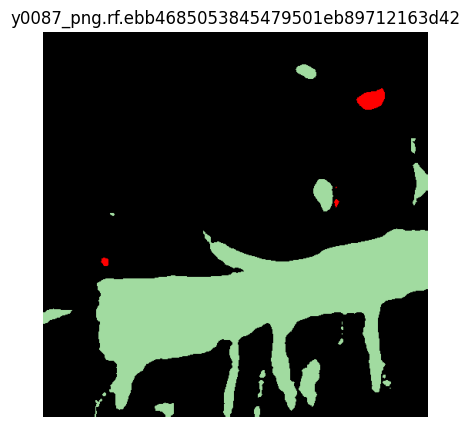

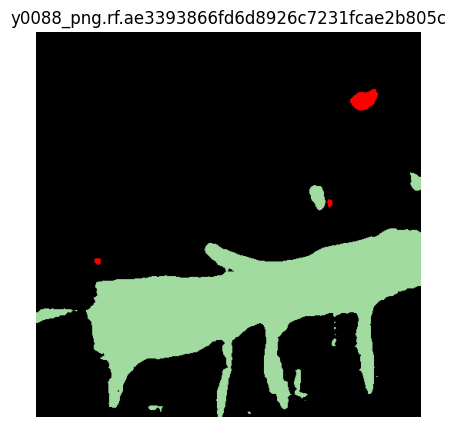

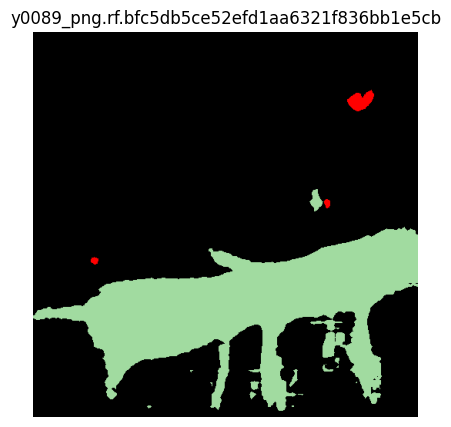

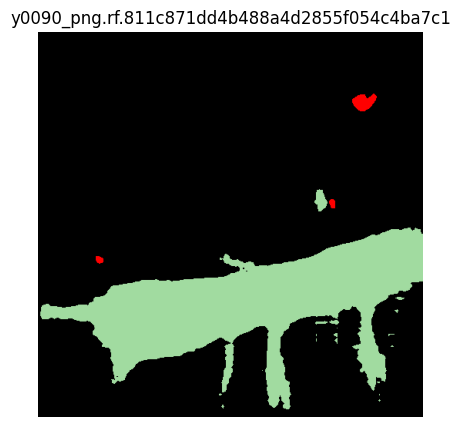

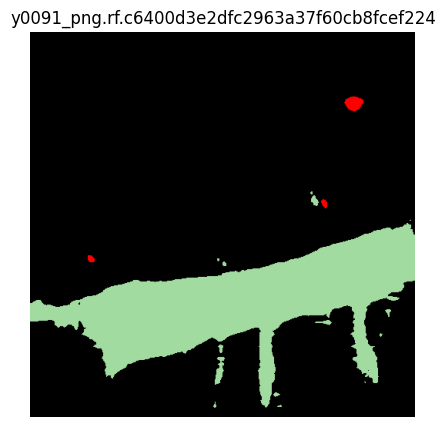

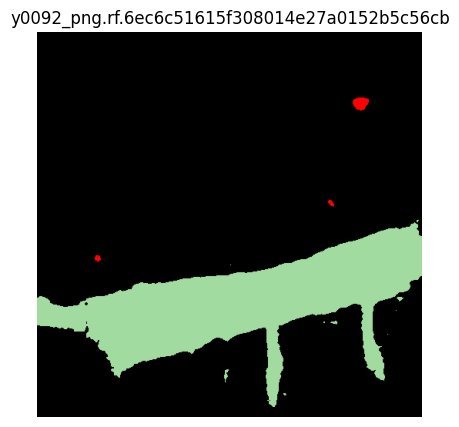

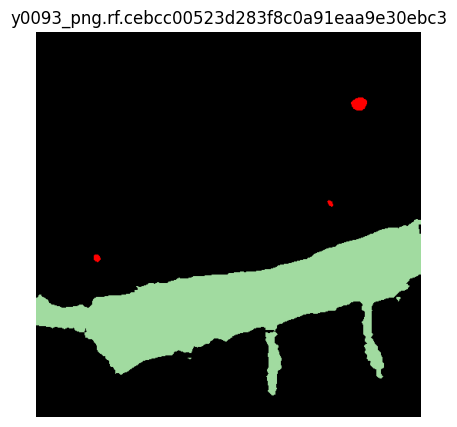

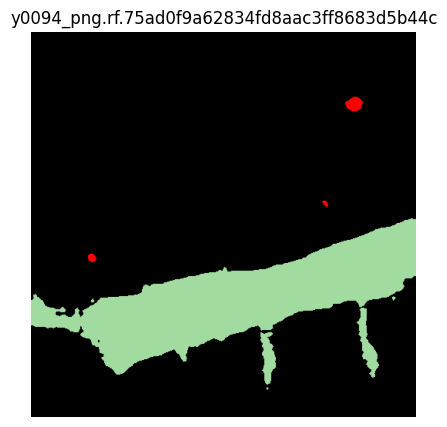

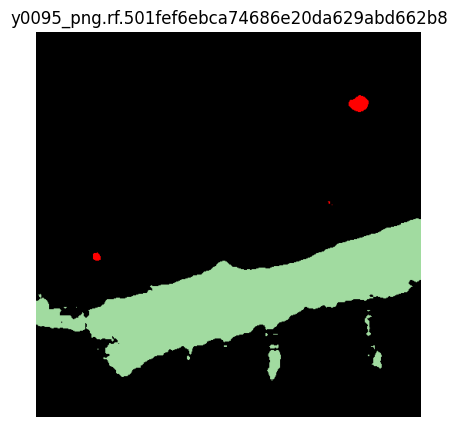

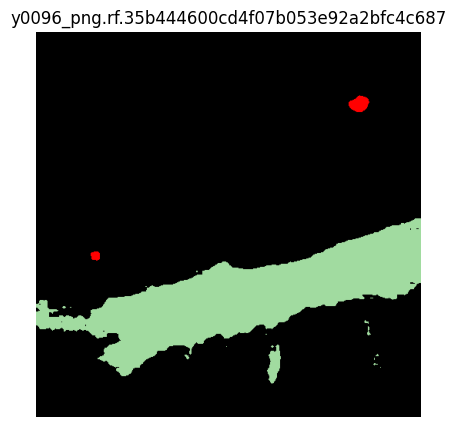

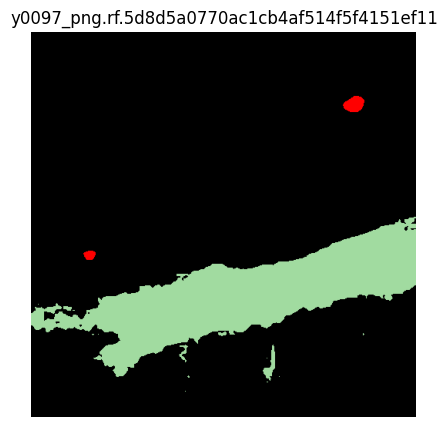

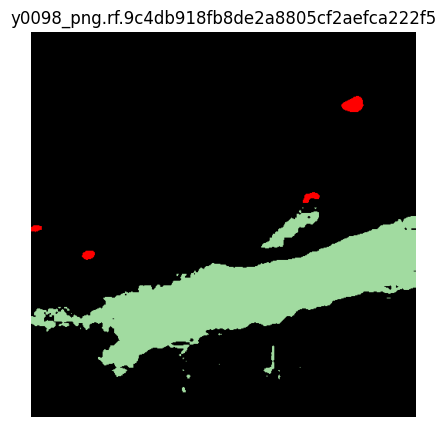

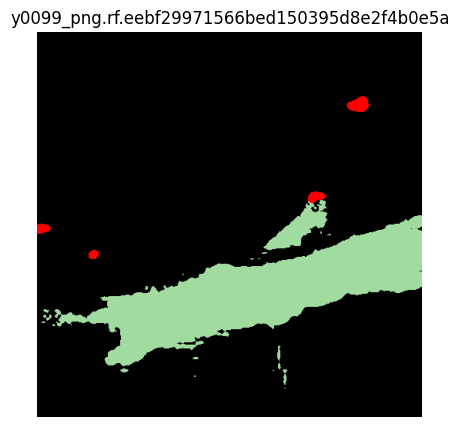

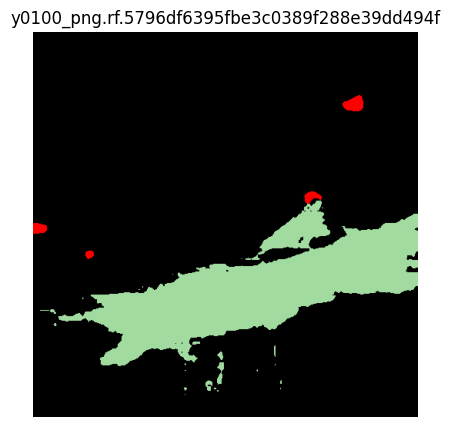

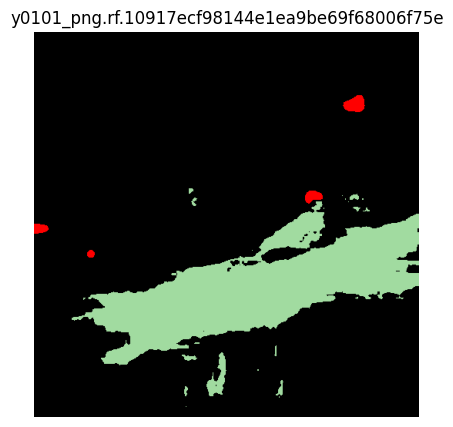

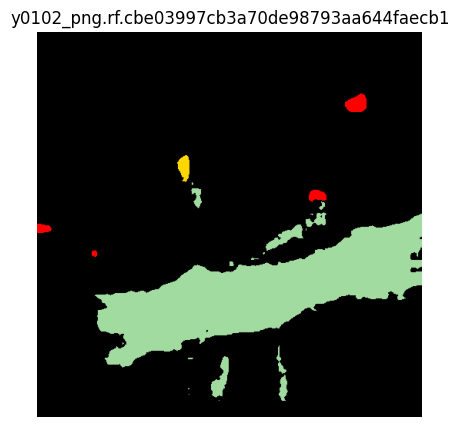

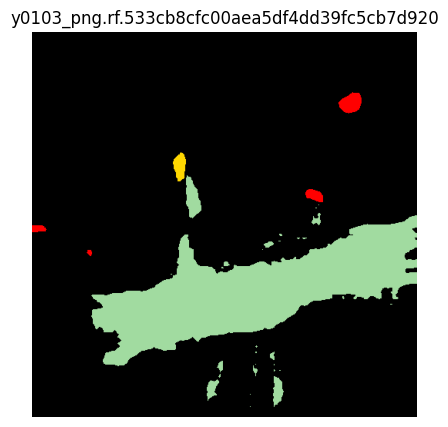

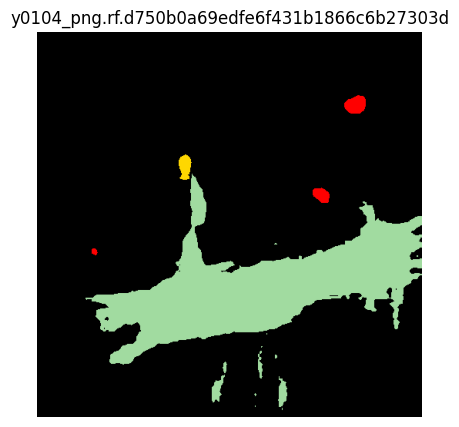

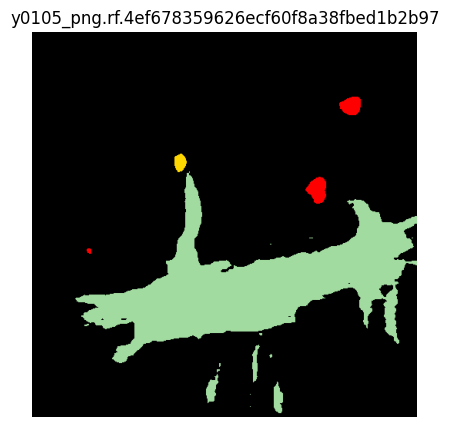

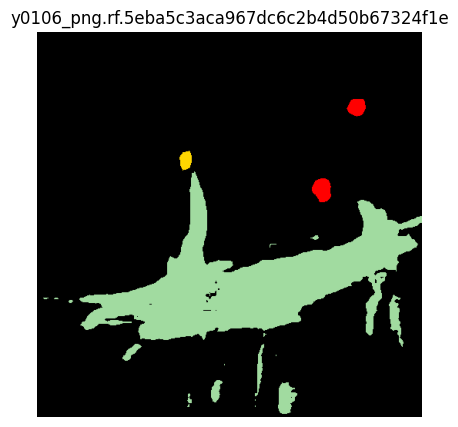

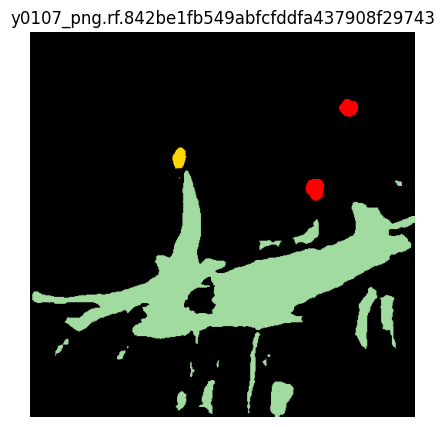

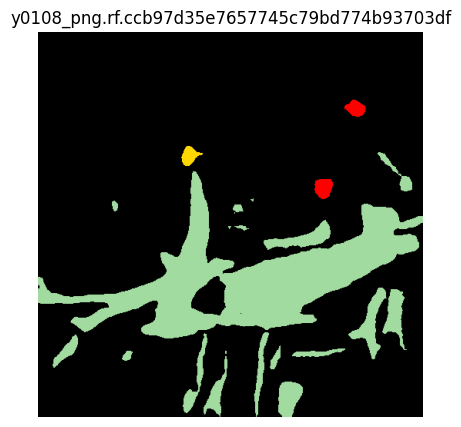

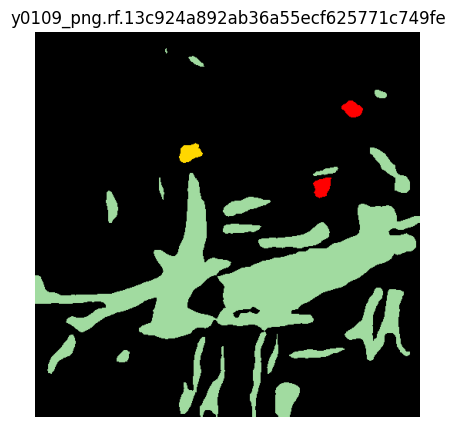

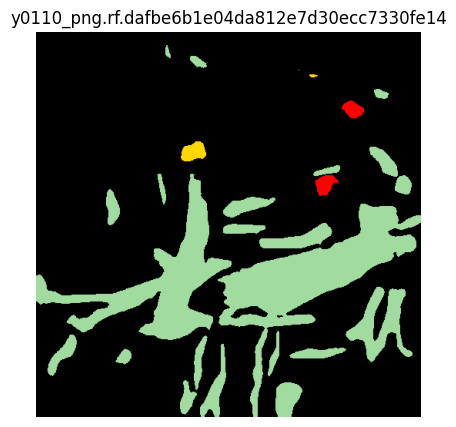

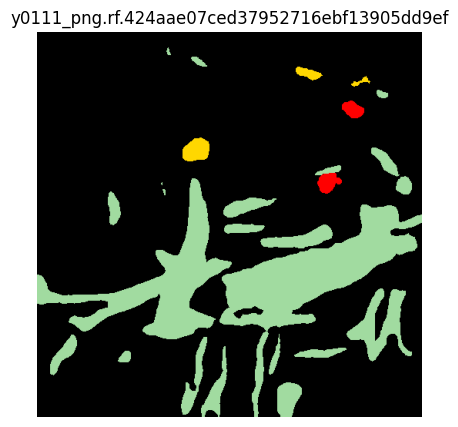

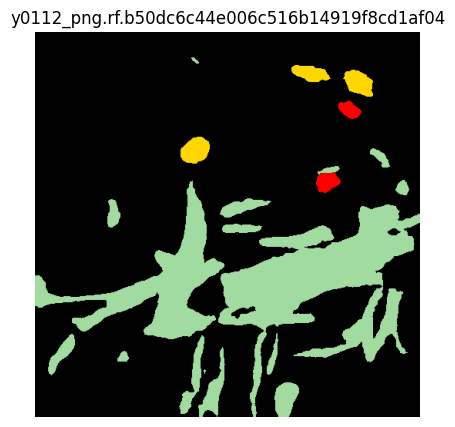

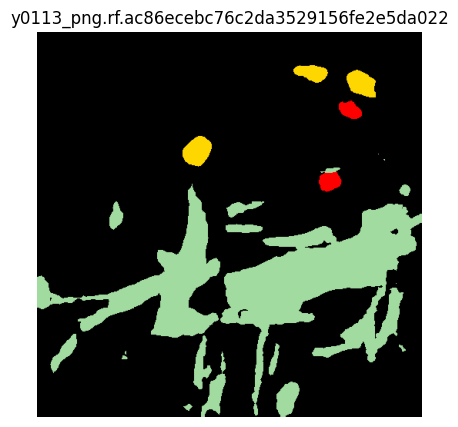

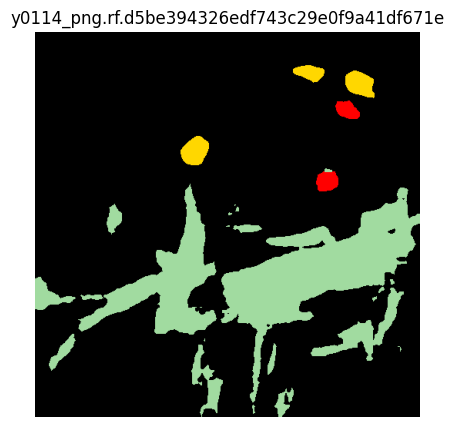

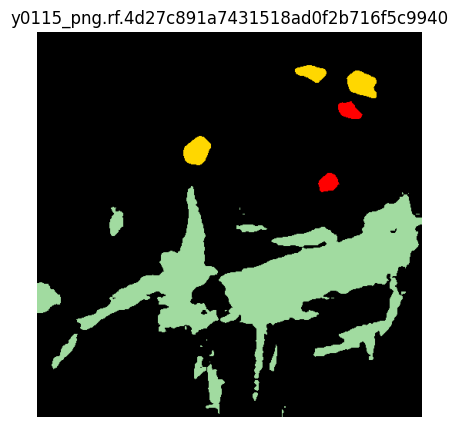

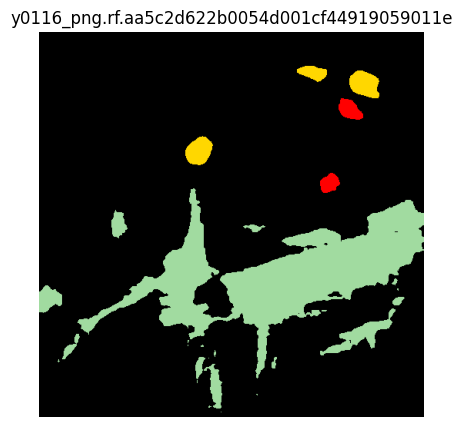

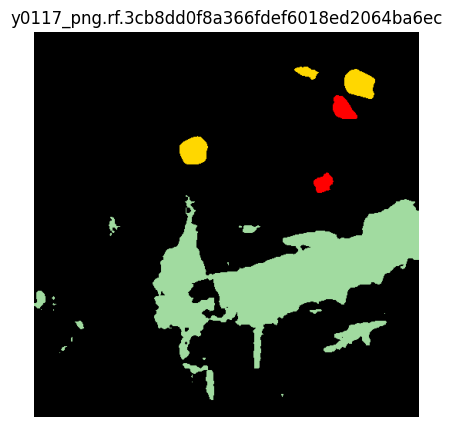

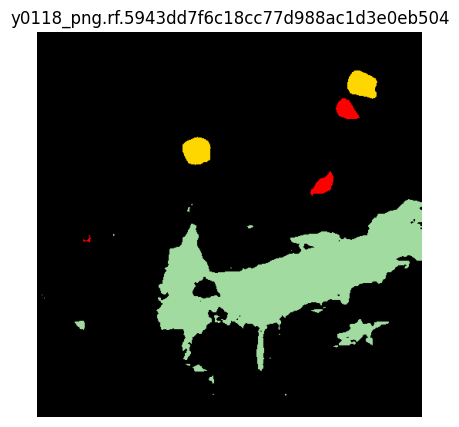

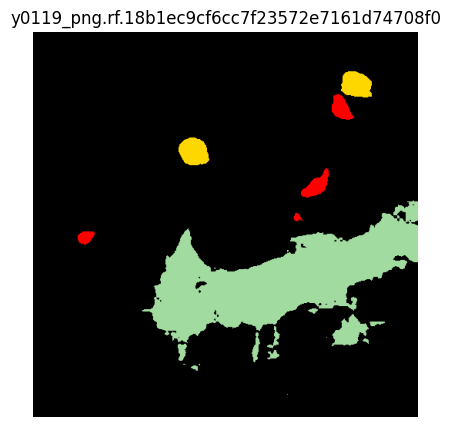

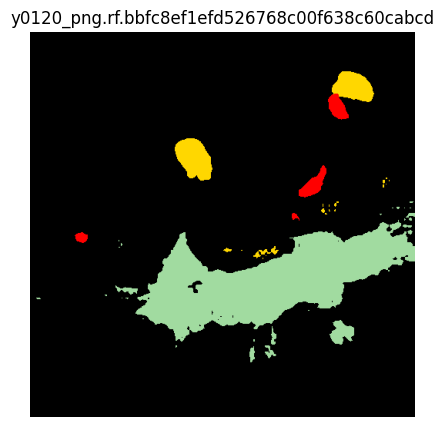

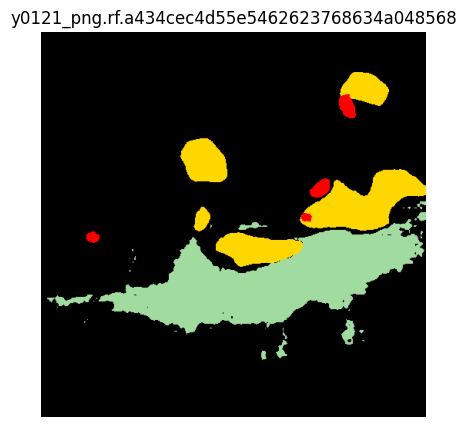

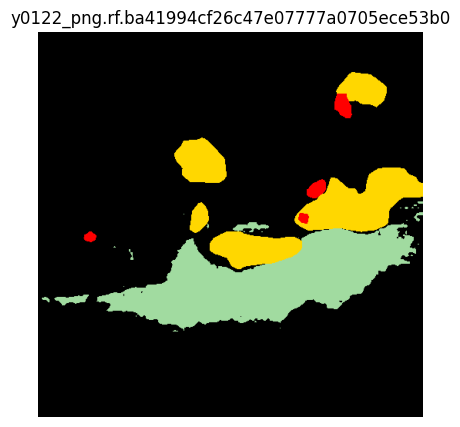

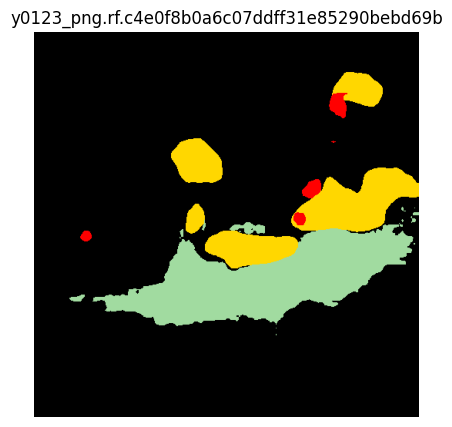

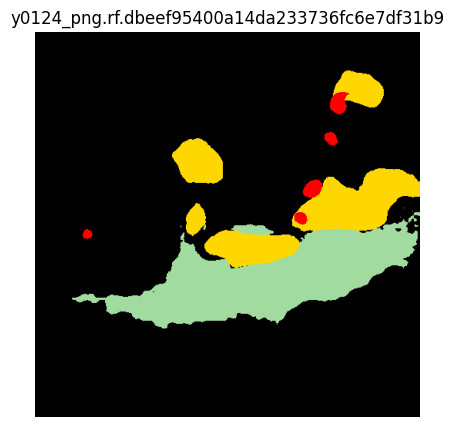

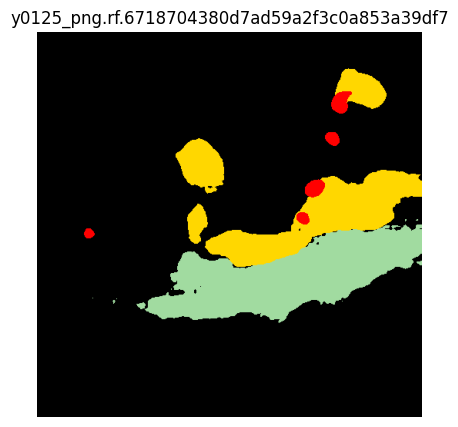

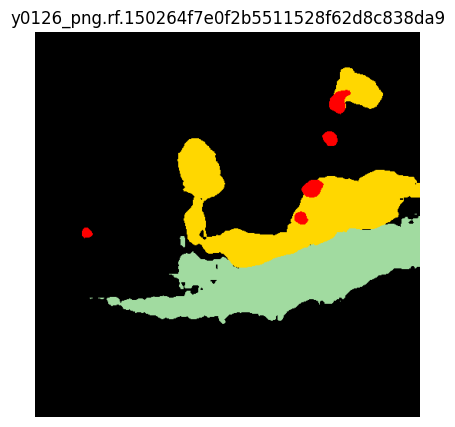

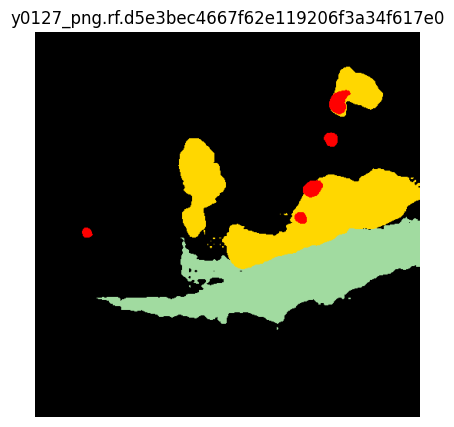

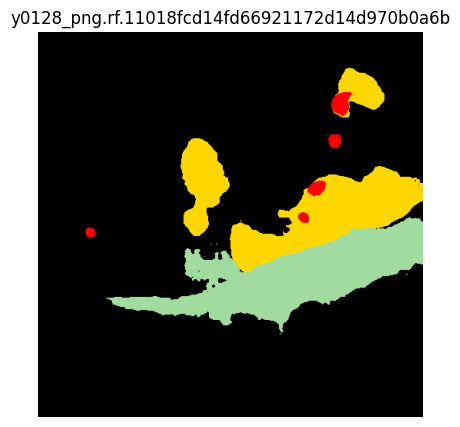

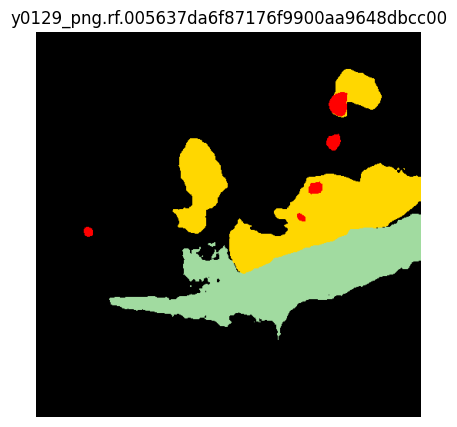

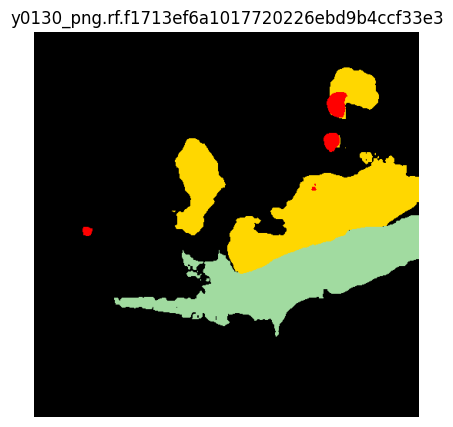

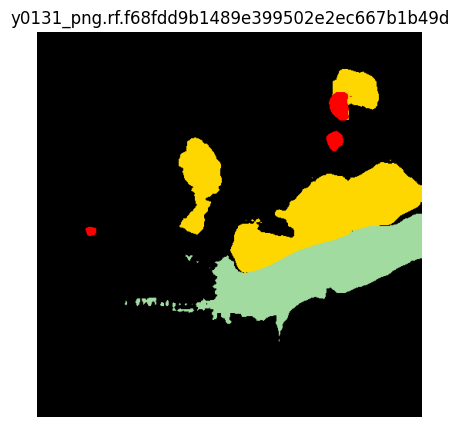

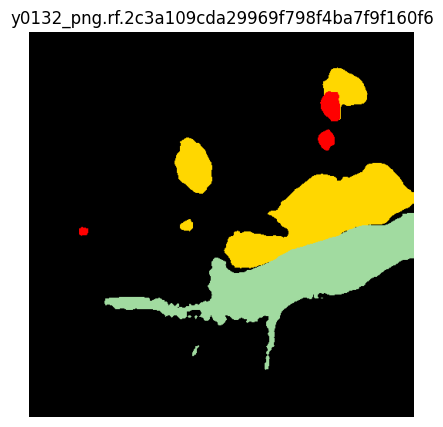

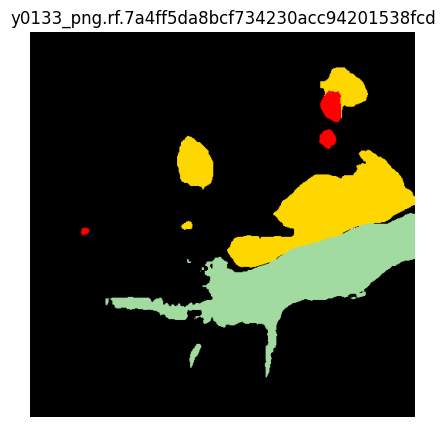

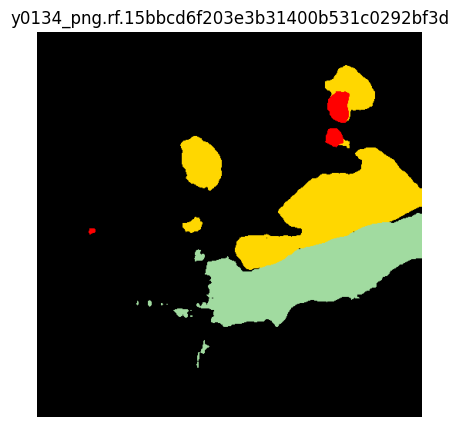

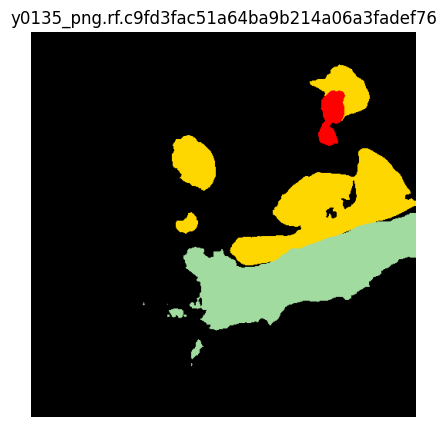

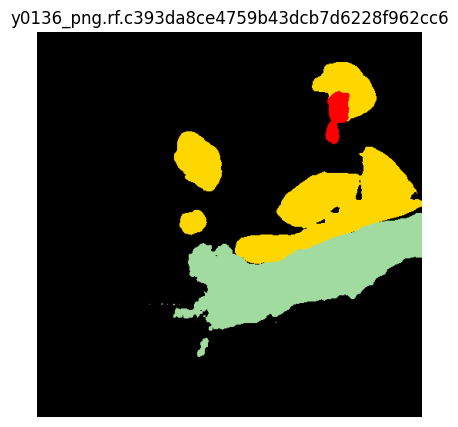

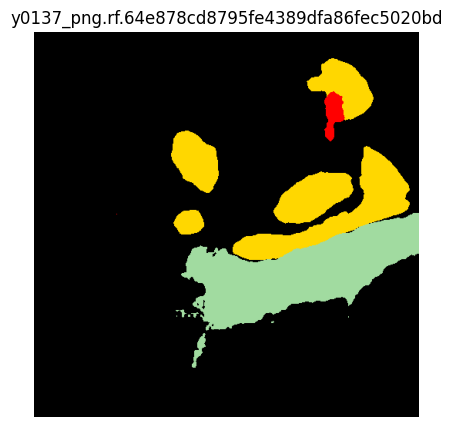

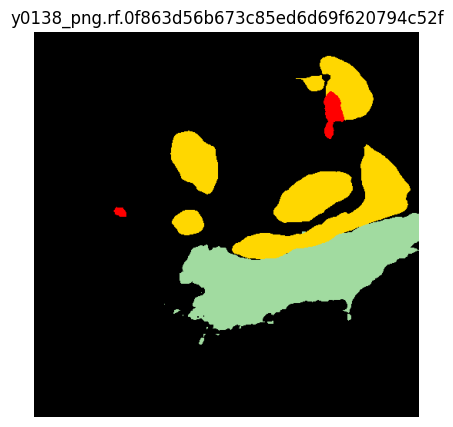

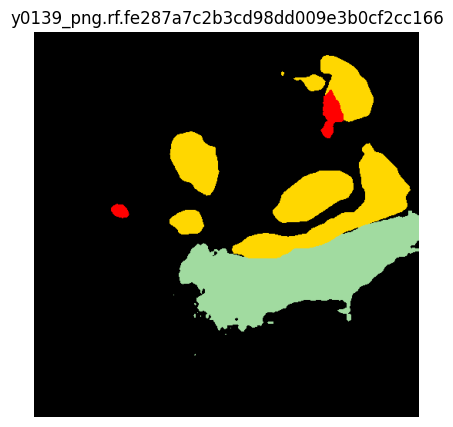

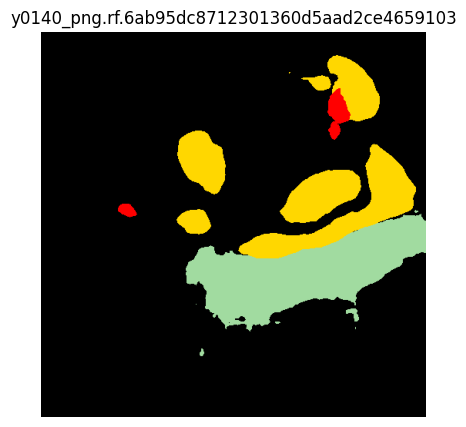

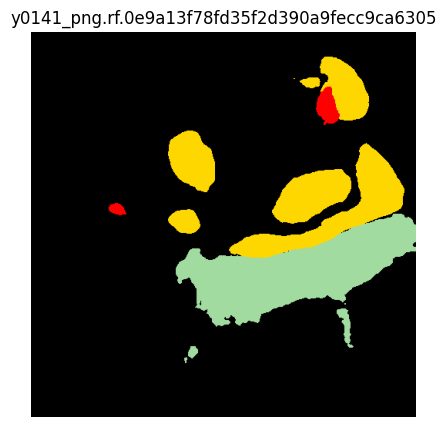

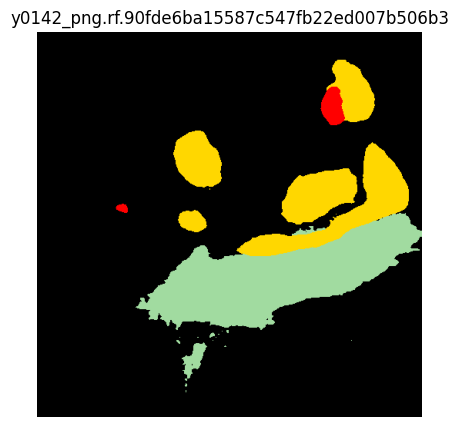

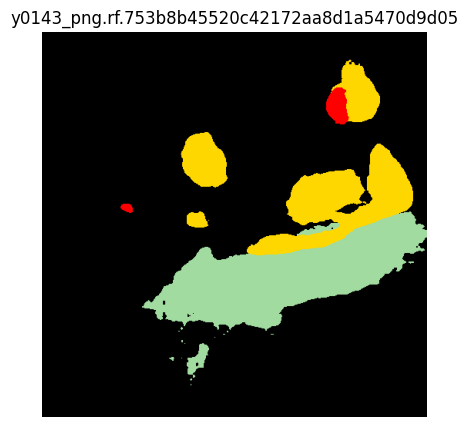

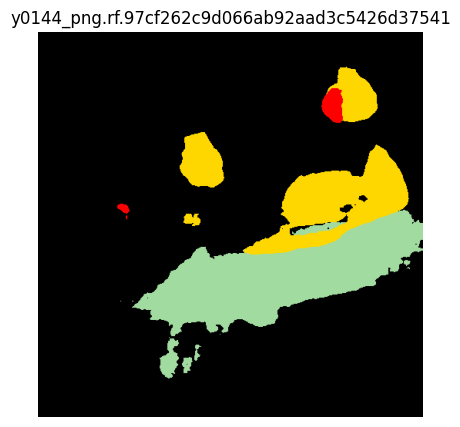

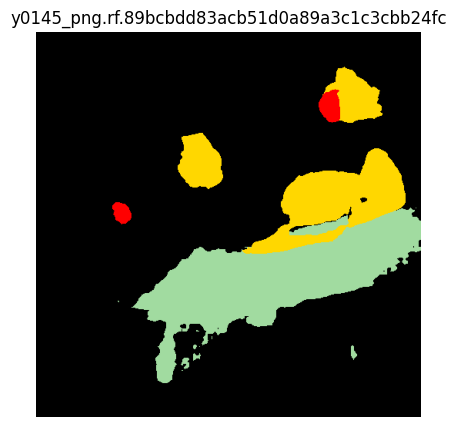

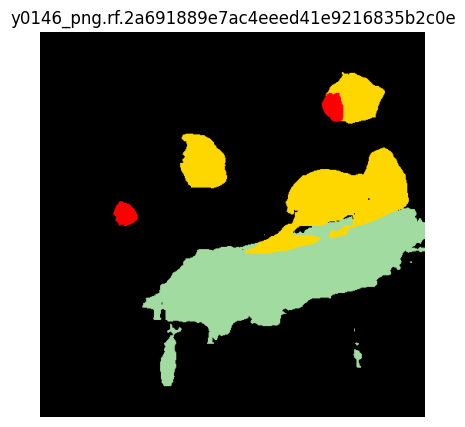

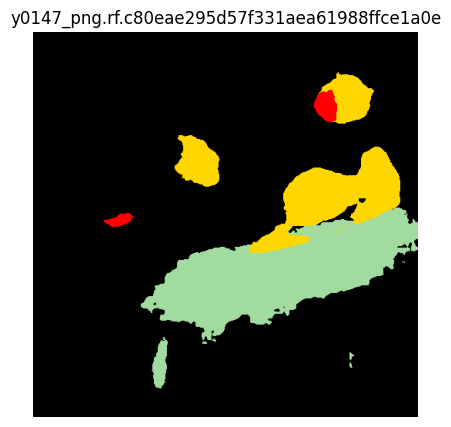

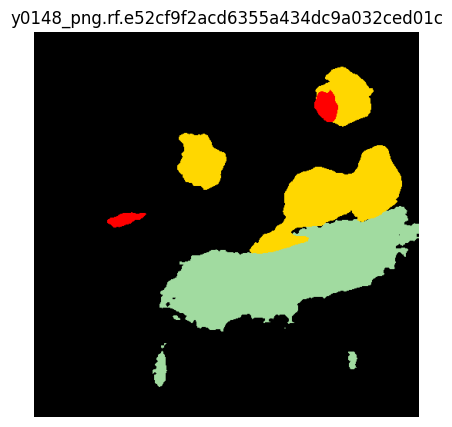

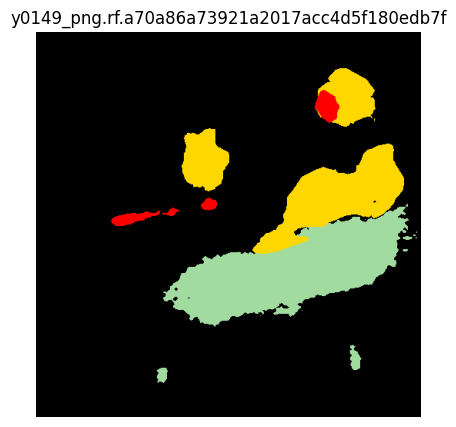

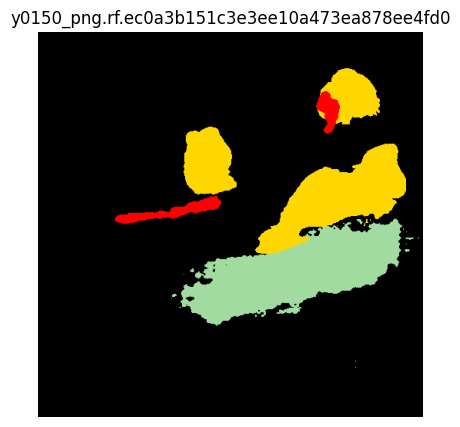

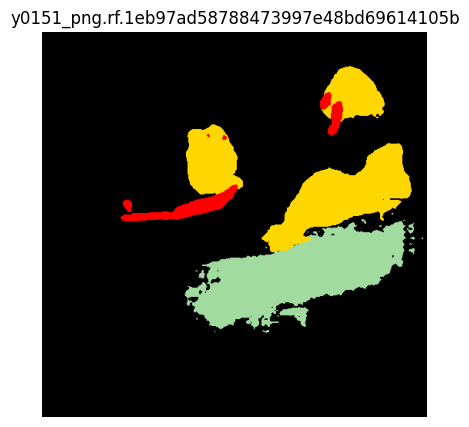

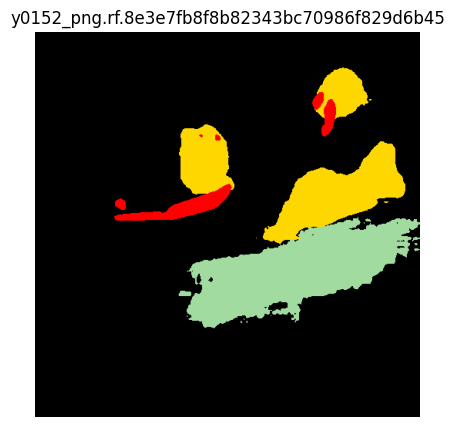

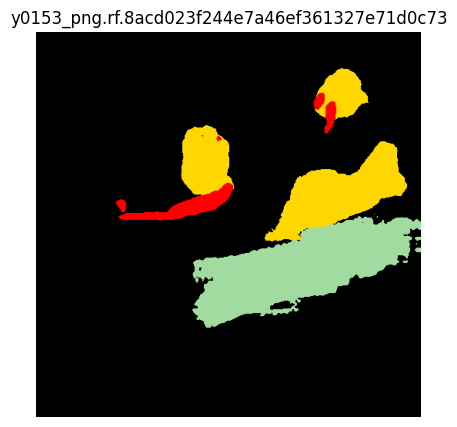

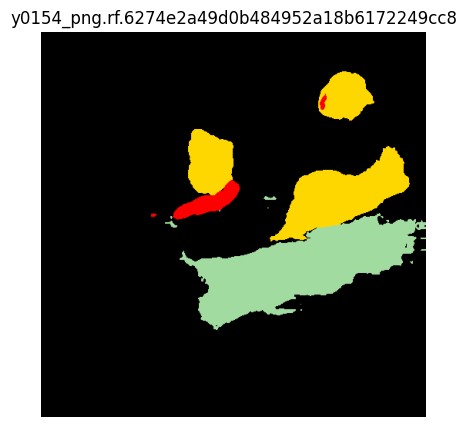

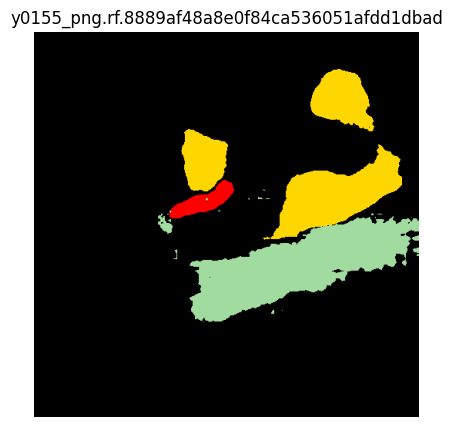

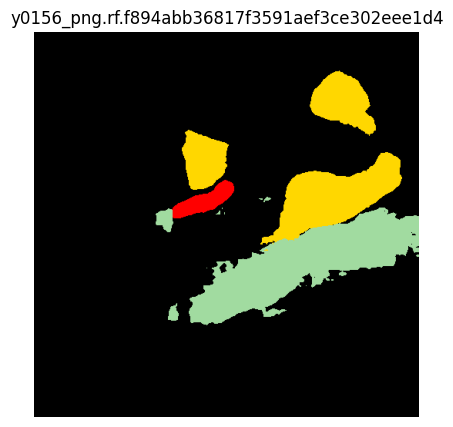

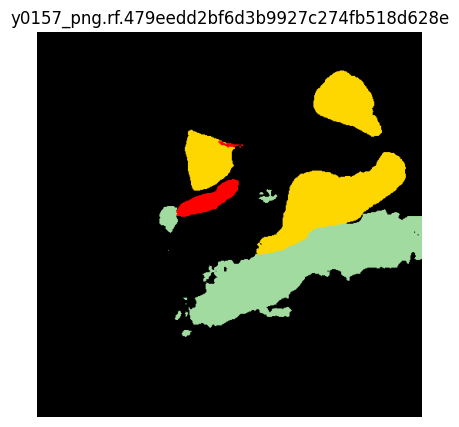

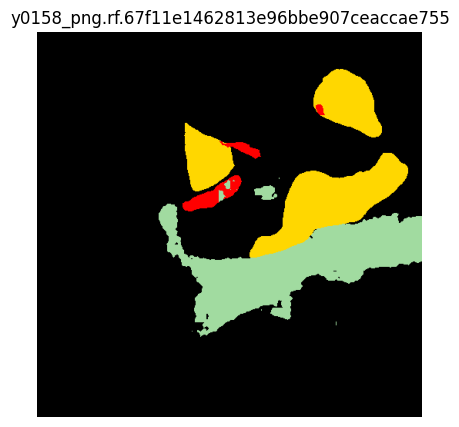

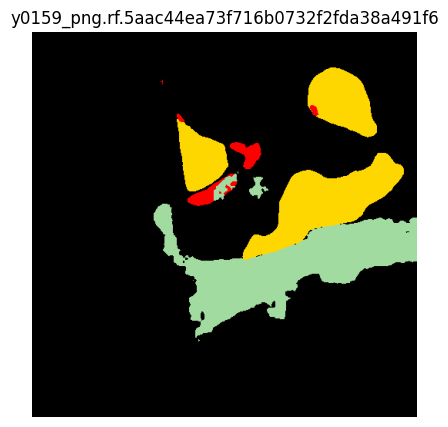

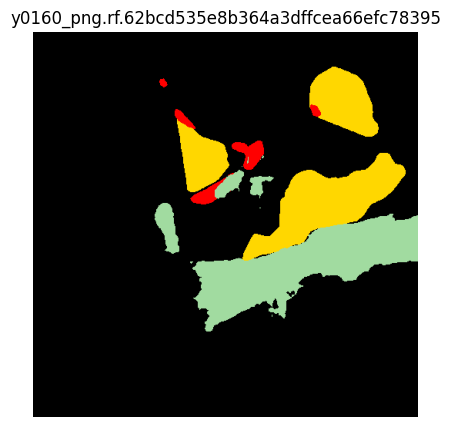

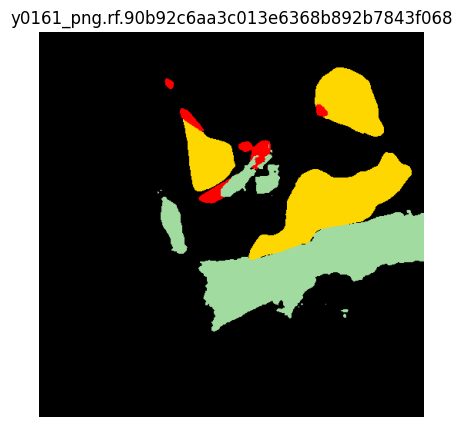

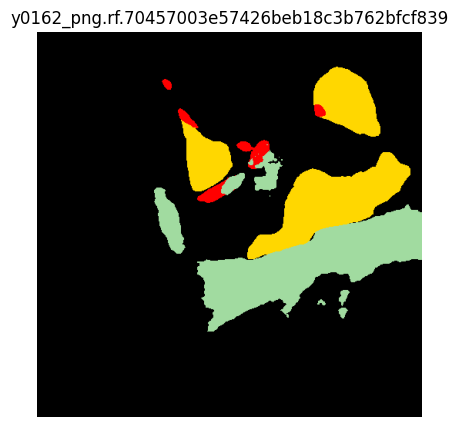

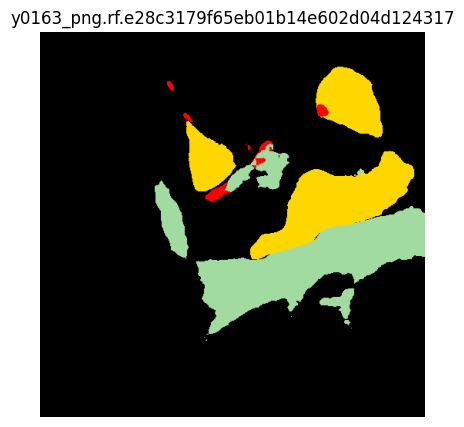

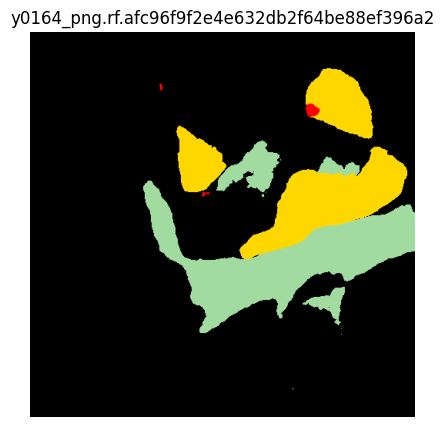

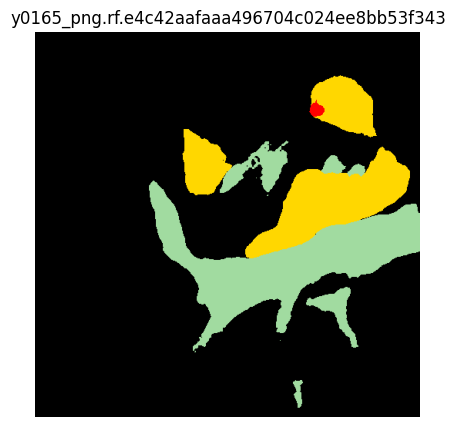

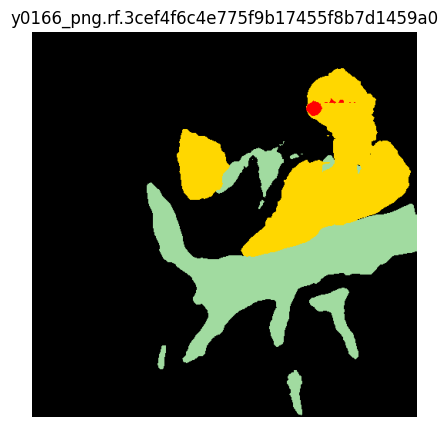

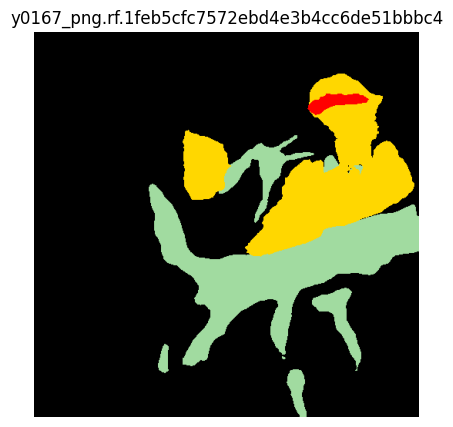

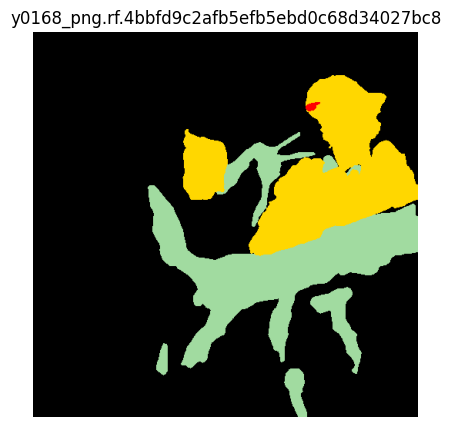

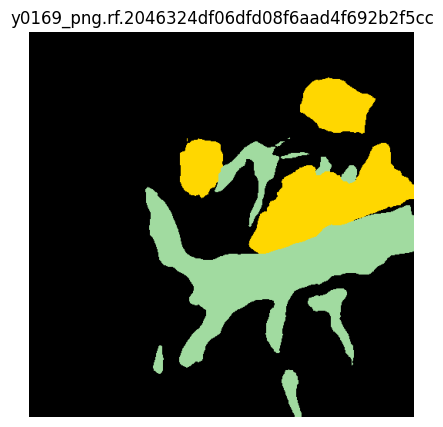

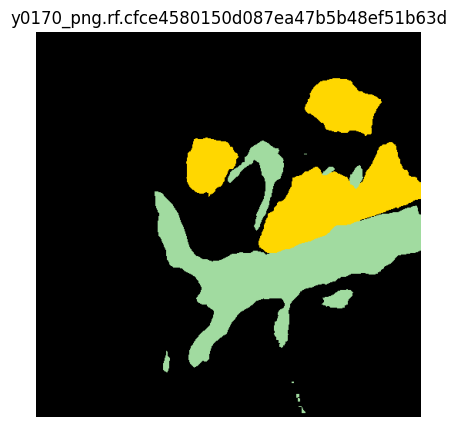

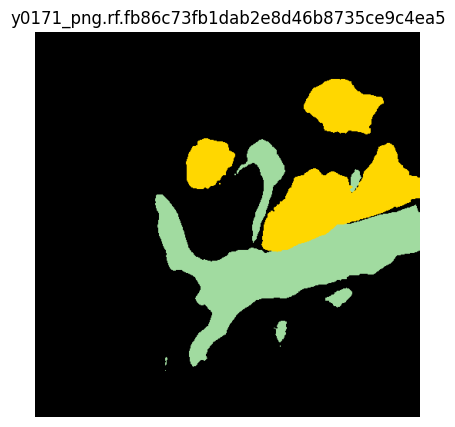

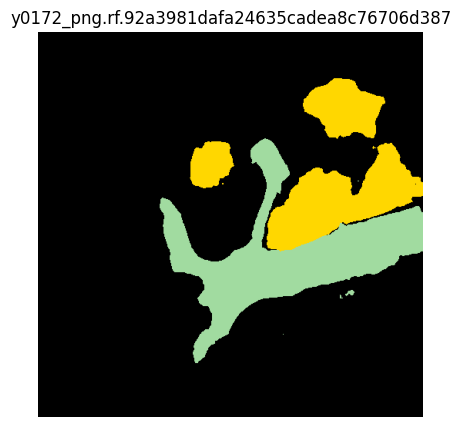

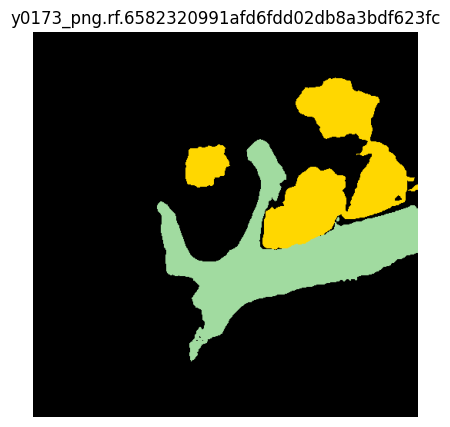

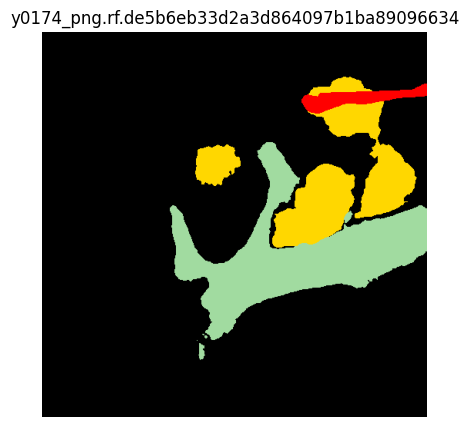

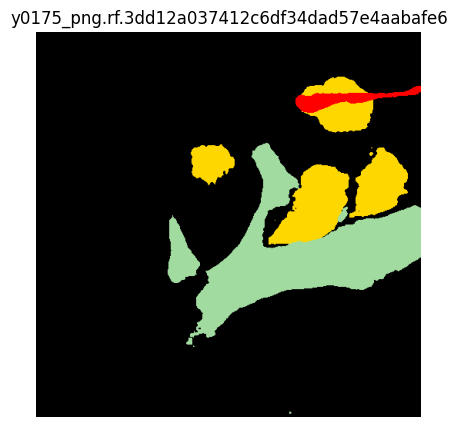

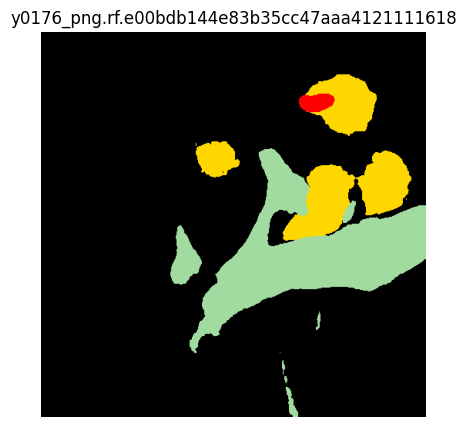

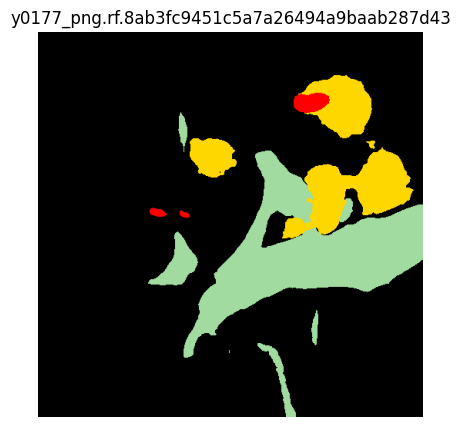

Excluding y0178_png.rf.5d8eaf9a8a388982d591c168dfaff111 for class 2


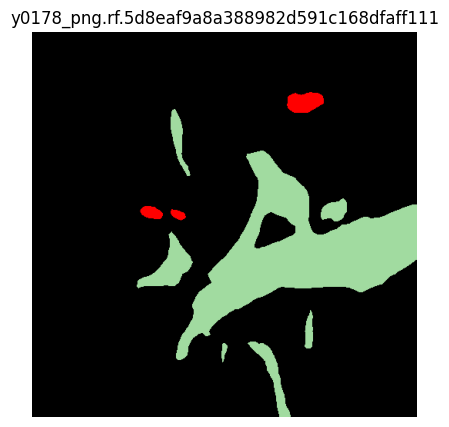

Excluding y0179_png.rf.d628804a6803bb818b62d9d2bd04bcc3 for class 2


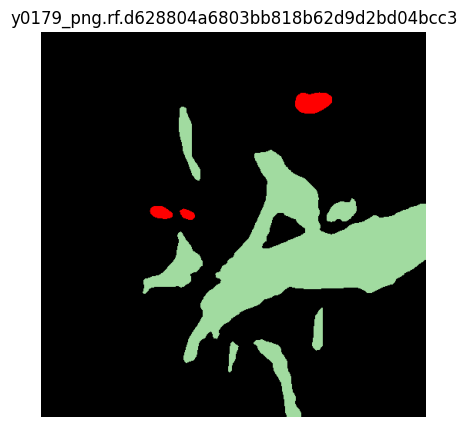

Excluding y0180_png.rf.dc9527476cf9d5a42a21a0f777d1736a for class 2


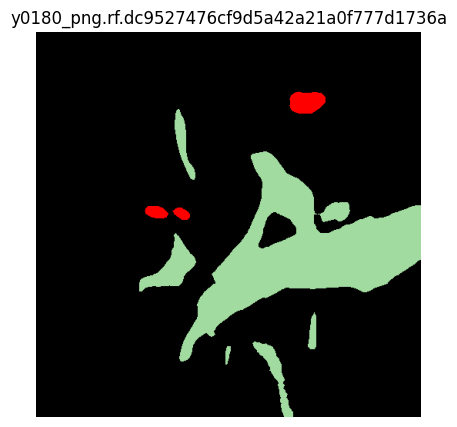

Excluding y0181_png.rf.ff392f31aa0b26203425c26664de3553 for class 2


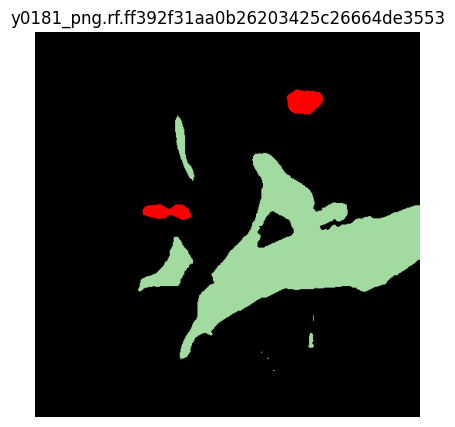

Excluding y0182_png.rf.6fa7aa48e220c9b23955538f3ce7776e for class 2


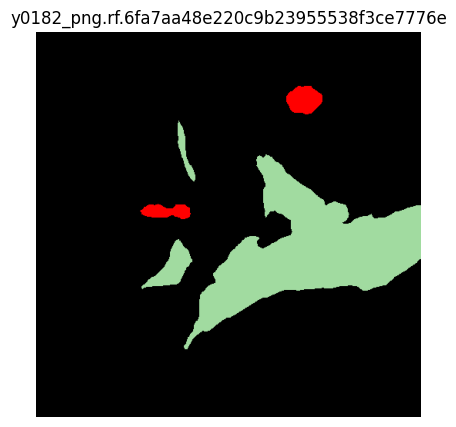

Excluding y0183_png.rf.10b454ff06bc4bdd583a8db0514763b5 for class 2


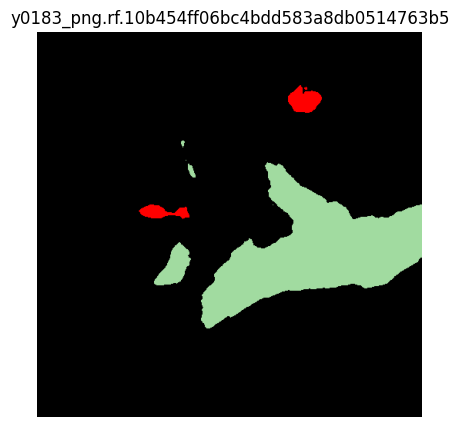

Excluding y0184_png.rf.a89ef5af442f4f1fc7fa581628cf98ed for class 2


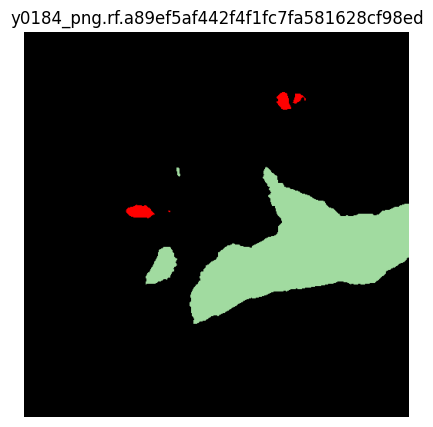

Excluding y0185_png.rf.368a271e1b49d0f07f27de33f9c5f84b for class 2


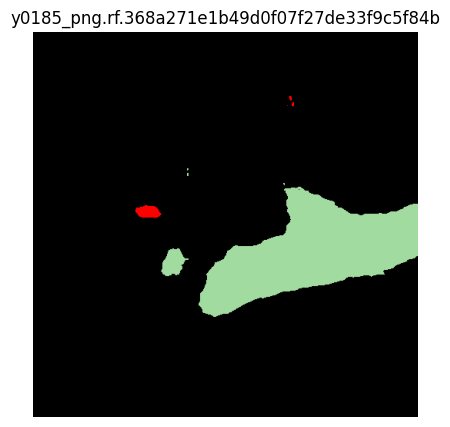

Excluding y0186_png.rf.90c3caf8f8dcd8c96e8461c83722808d for class 2


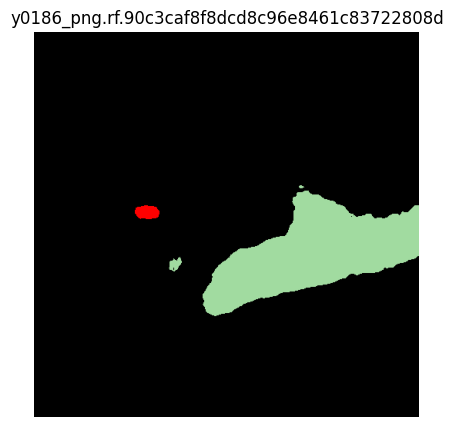

Excluding y0187_png.rf.135593666d114ab20eaeba9be1ff93ae for class 2


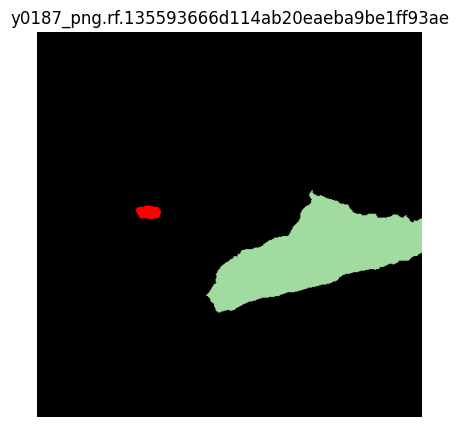

Excluding y0188_png.rf.c9e15be1d0e878c32d210a8acf9e44b3 for class 2


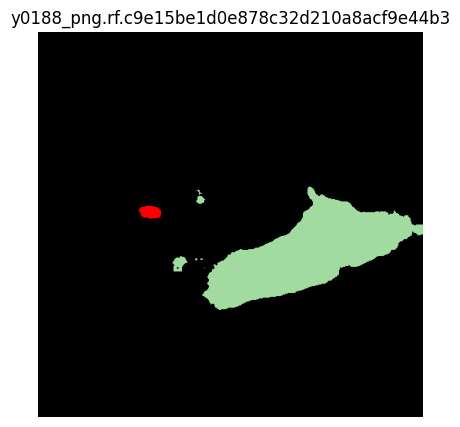

Excluding y0189_png.rf.67869a8f23033d2ab8bf9fa9f950eb8d for class 2


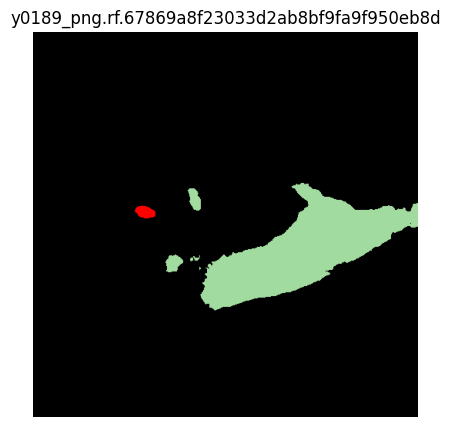

Excluding y0190_png.rf.04d231b184a35e6803179cd9d0ddc225 for class 2


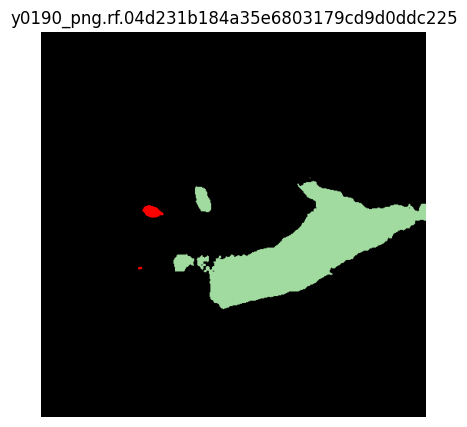

Excluding y0191_png.rf.fe61847dca3e6832663a2099cb9508e7 for class 2


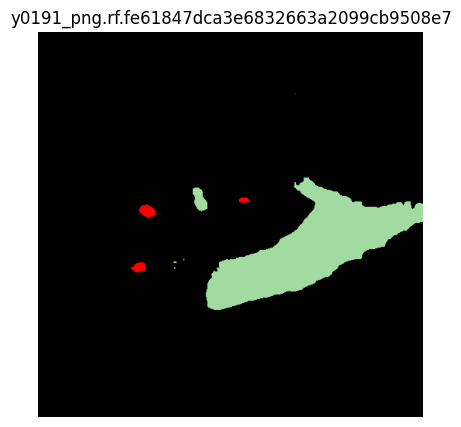

Excluding y0192_png.rf.1caf202bb41de03b062e6e70860c7248 for class 2


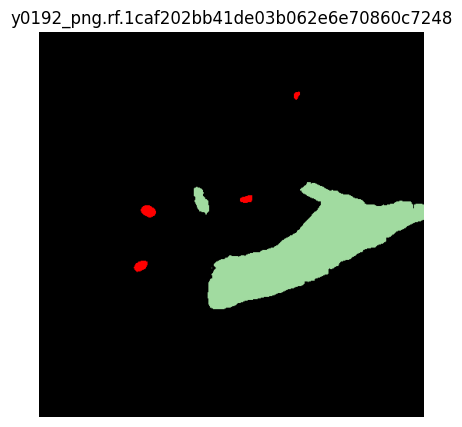

Excluding y0193_png.rf.71c60a265fd7e40f87ec4926873033a7 for class 2


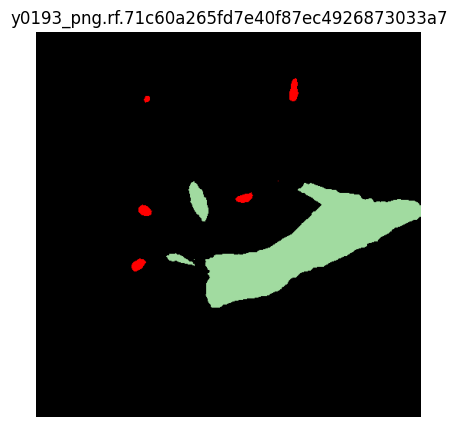

Excluding y0194_png.rf.ac88de6a94f26d7aa53b3a3232da0862 for class 2


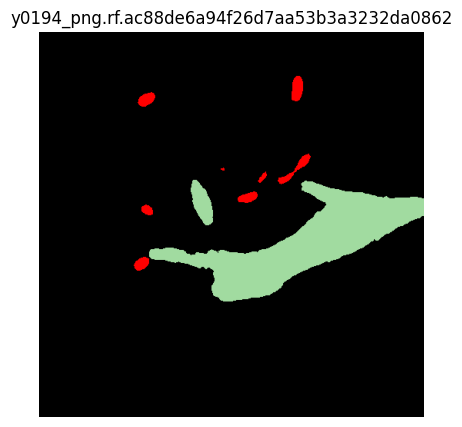

Excluding y0195_png.rf.5699794e6e699ecf6dd841bf795aa937 for class 2


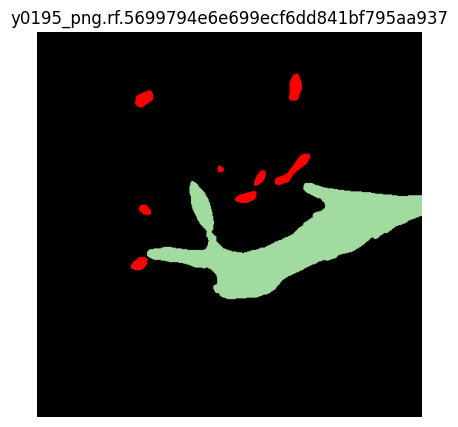

Excluding y0196_png.rf.d93696e829ed80841524af93dd1b09f1 for class 2


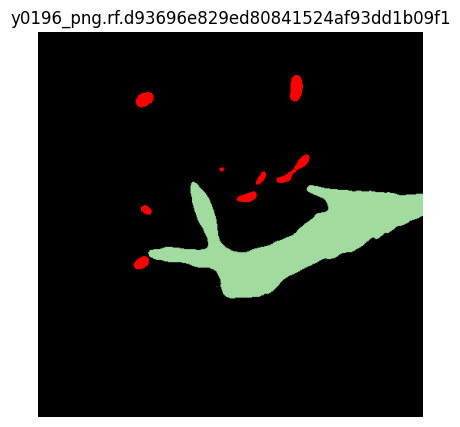

Excluding y0197_png.rf.55aac99f9ea8166df7226877f9d3d2f7 for class 2


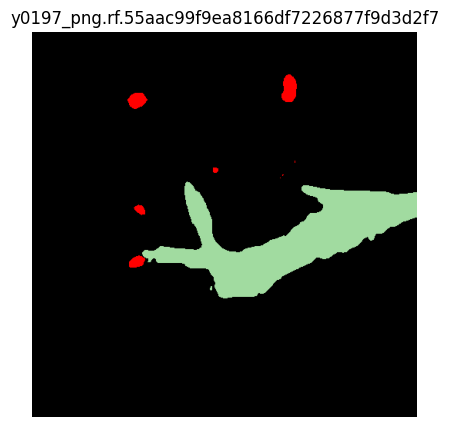

Excluding y0198_png.rf.bbf0a052be55a43da60b72cee260e5da for class 2


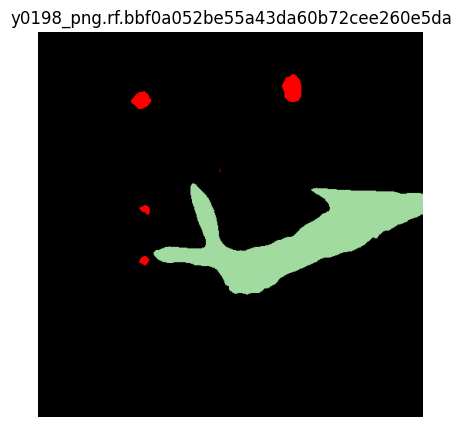

Excluding y0199_png.rf.c301facb0cb2661675752fba0b102323 for class 2


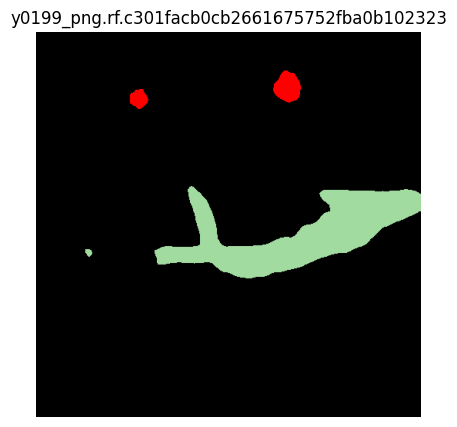

Excluding y0200_png.rf.a6bfdba12d21c14c0de757bce5fff15f for class 2


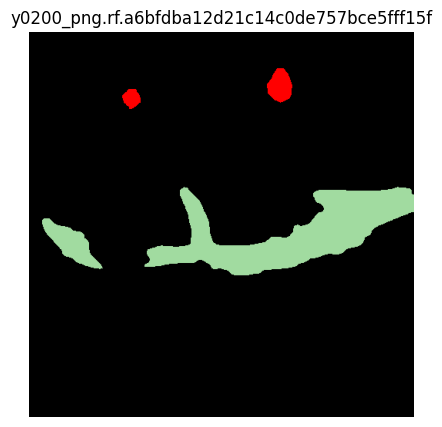

Excluding y0201_png.rf.29f8da4c9bc6e585eb1c04092303db5c for class 2


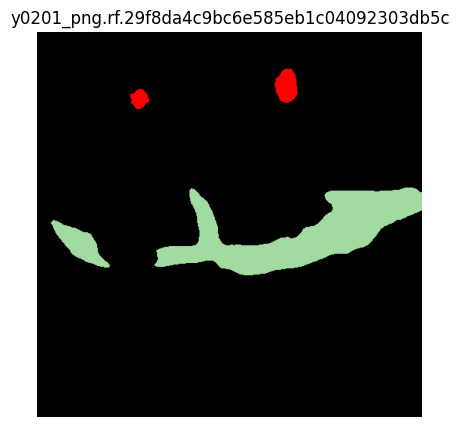

Excluding y0202_png.rf.6b2eec373053f78c5981212a1f0d43cb for class 2


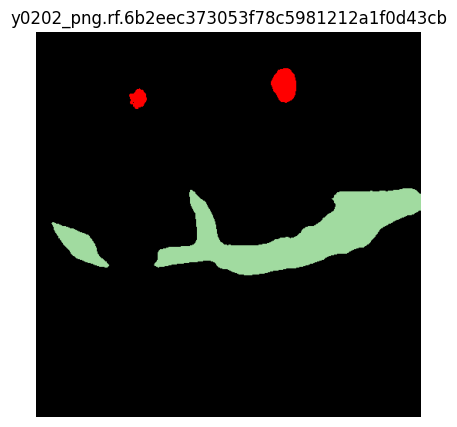

Excluding y0203_png.rf.b1ada97c5b1ee5059f34a2268337fd2f for class 2


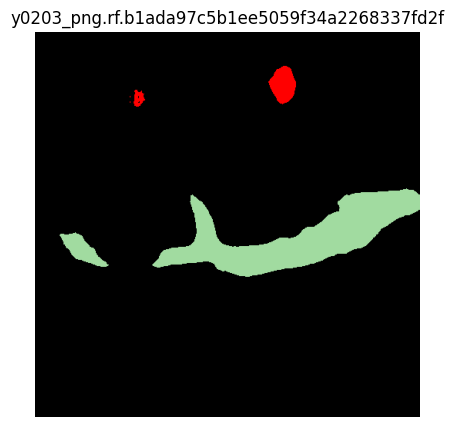

Excluding y0204_png.rf.c8772b563d9ad1ef083a6608603878e7 for class 2


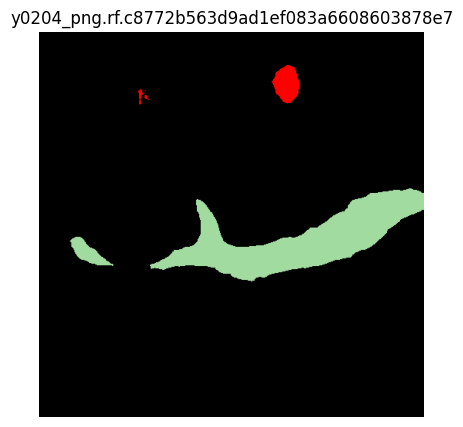

Excluding y0205_png.rf.38be1a0e7532dd3d05a374718dfeea70 for class 2


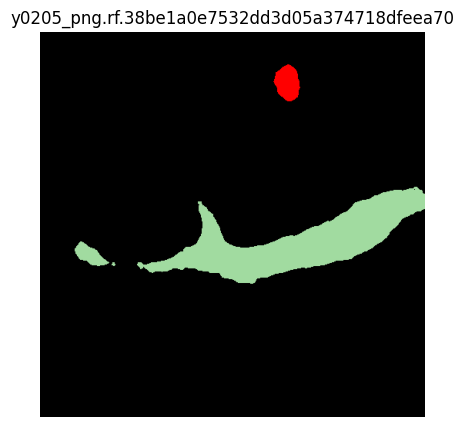

Excluding y0206_png.rf.e9c6f4f376c1274558a6a424ffbec3b5 for class 2


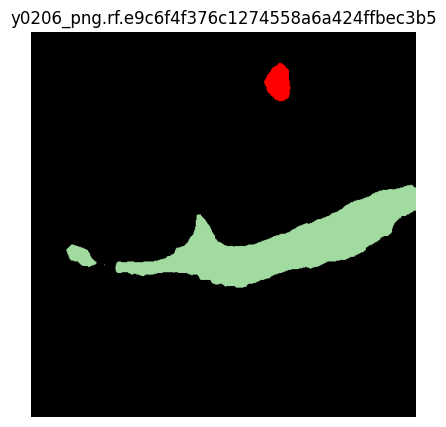

Excluding y0207_png.rf.b12ed8c9d796a9903d9a84cf4546b368 for class 2


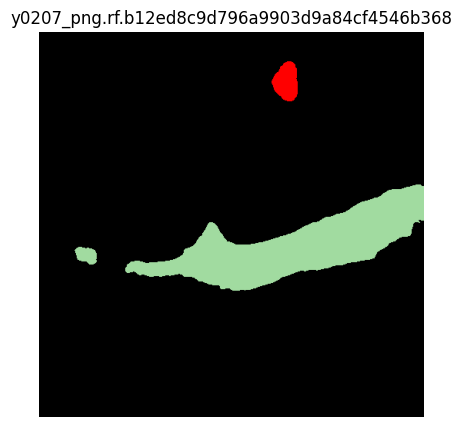

Excluding y0208_png.rf.cd2cf17505061026200ceb0f447db77d for class 2


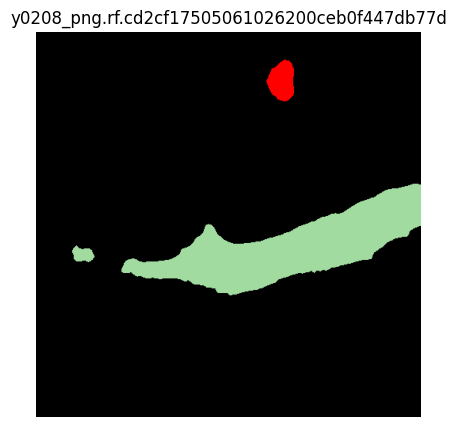

Excluding y0209_png.rf.cf45bd24729b50459398b16b74dfed9b for class 2


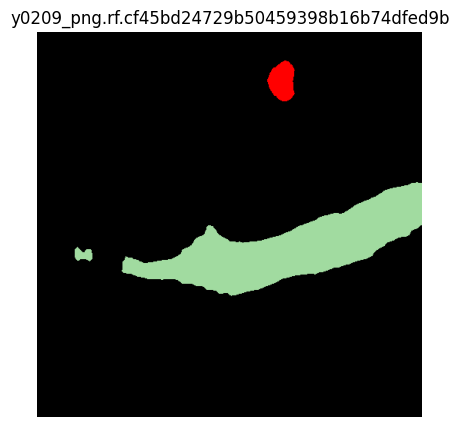

Excluding y0210_png.rf.15e6f6f2b307725bf3ec6b9643c54be9 for class 2


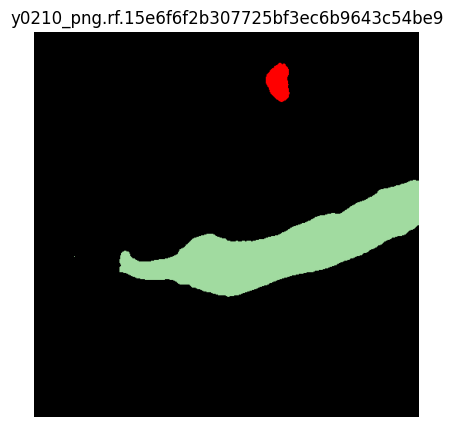

Excluding y0211_png.rf.c9c3c93c8ded71938a6ccbef3f09a5cc for class 2


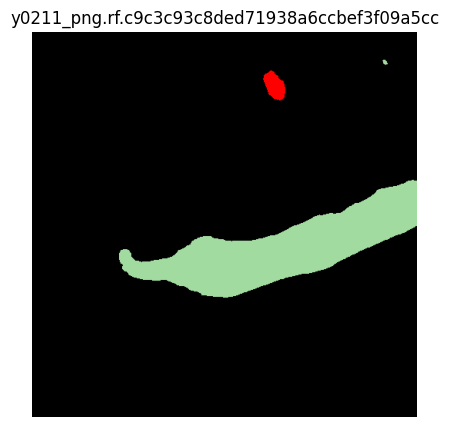

Excluding y0212_png.rf.50d6670e28a73363f52aed82b2215fdf for class 2


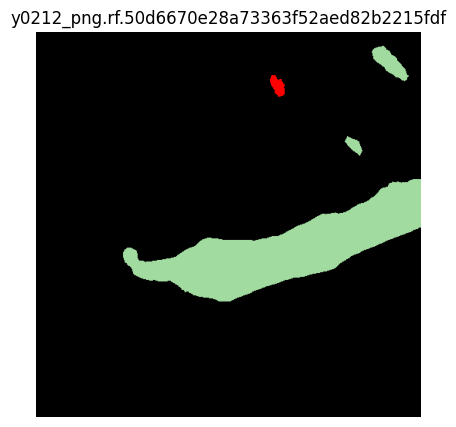

Excluding y0213_png.rf.66409abd16e1f4644a49ec26e59afd31 for class 2


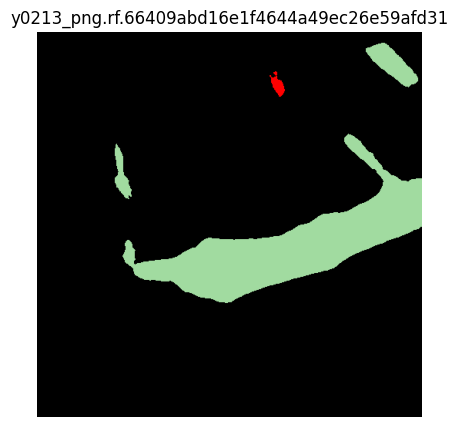

Excluding y0214_png.rf.ba71db33964ab752c7d12607012df535 for class 2


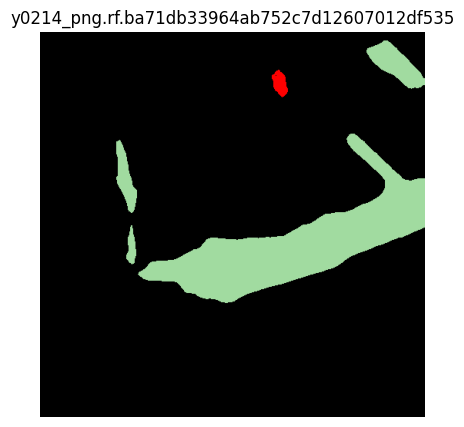

Excluding y0215_png.rf.6cd0840a53f89bb5f17485c23cd29cd4 for class 2


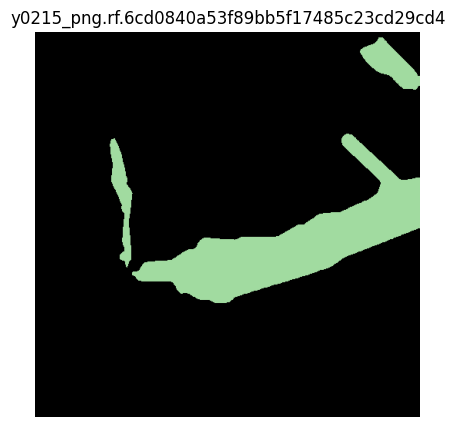

Excluding y0216_png.rf.f6e3f63f5899d2f920af456193db2439 for class 2


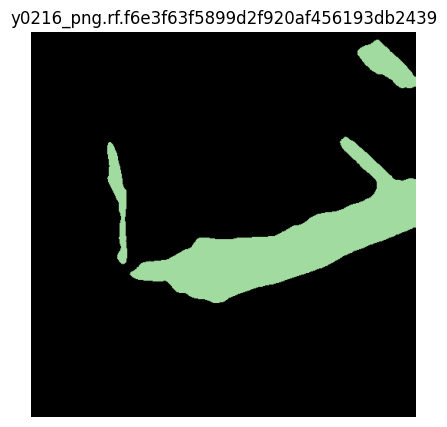

Excluding y0217_png.rf.2acc5f20fef5caae2012febe765cc5c4 for class 2


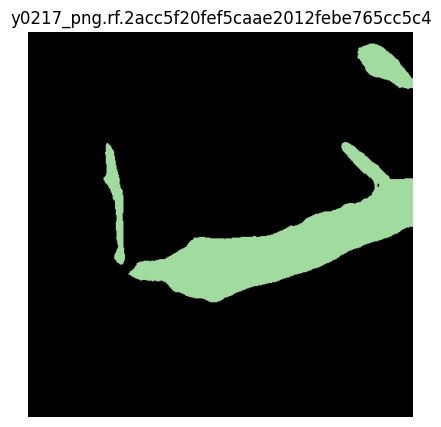

Excluding y0218_png.rf.9644d9d463f3e6cf2b0fe80da1874717 for class 2


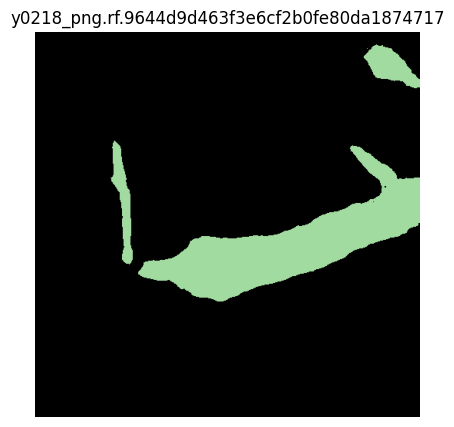

Excluding y0219_png.rf.543f0c3e33ec1c661537c814fde6e5b4 for class 2


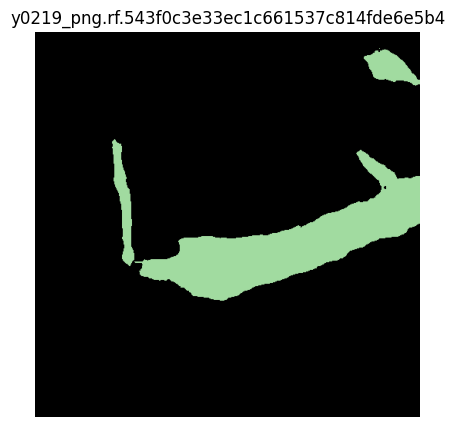

Excluding y0220_png.rf.d84aa1a5a80e6ce3f6cbb4c628583415 for class 2


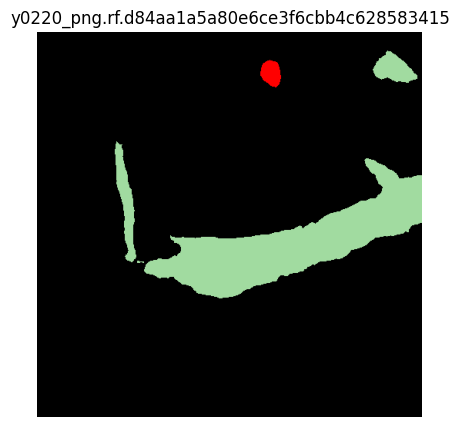

Excluding y0221_png.rf.5ac314139763824e9262e65a661b3823 for class 2


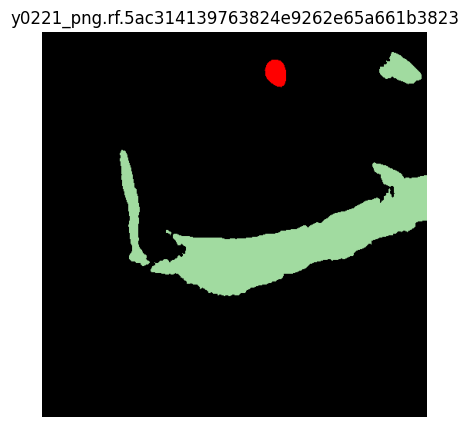

Excluding y0222_png.rf.2a397fc39391c260147881da390c99cb for class 2


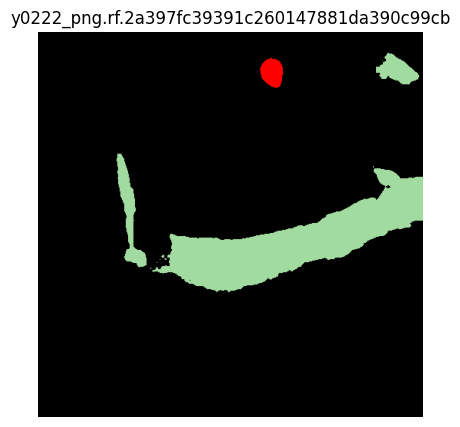

Excluding y0223_png.rf.78215b7e8fba9d0a2f413c31684a317a for class 2


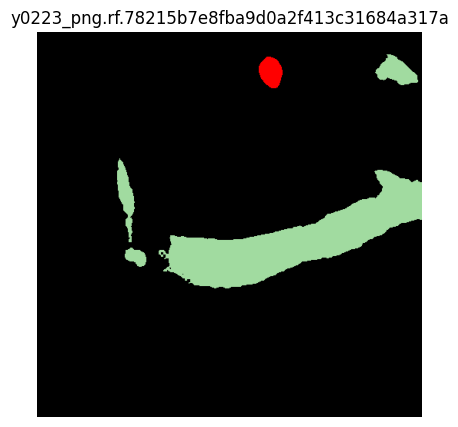

Excluding y0224_png.rf.1f49eb5cedc04117e8b56ff1712cd0d6 for class 2


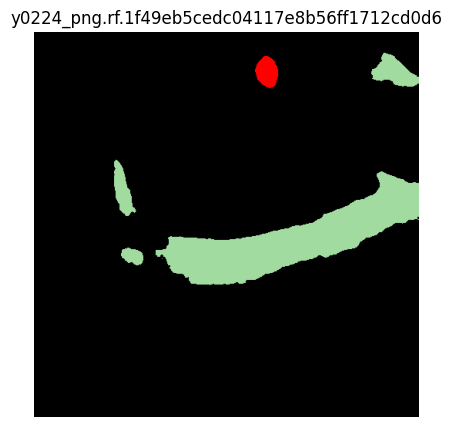

Excluding y0225_png.rf.2857bf3de39eb701eb2c8a93009d3294 for class 2


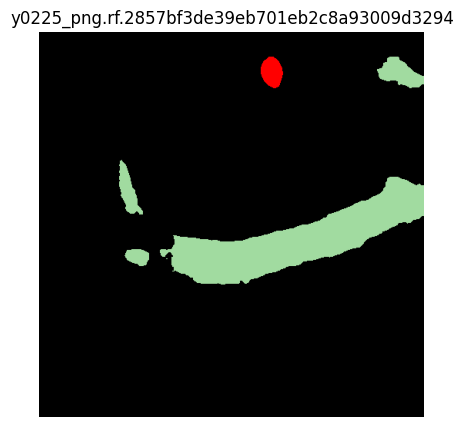

Excluding y0226_png.rf.6f8a386ad890c7436d173618bca9bf6f for class 2


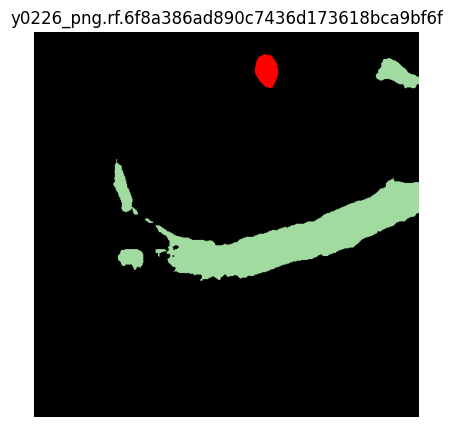

Excluding y0227_png.rf.2297c4d9a6f3f1c4614f6ba7383fdf6e for class 2


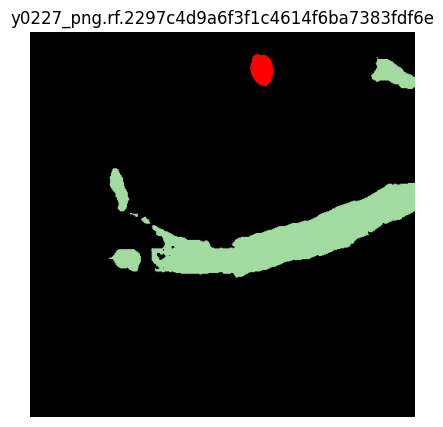

Excluding y0228_png.rf.e4ea22cca35603c28e880e6487933994 for class 2


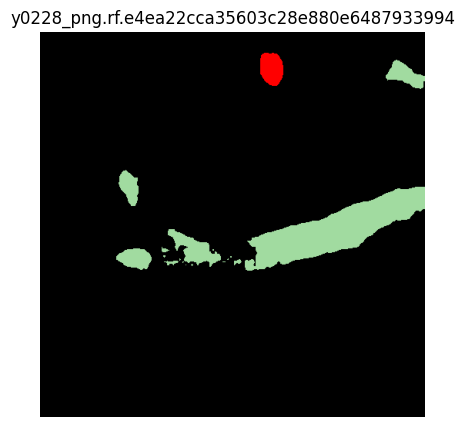

Excluding y0229_png.rf.9a6300e8028da257138369cf96d844f1 for class 2


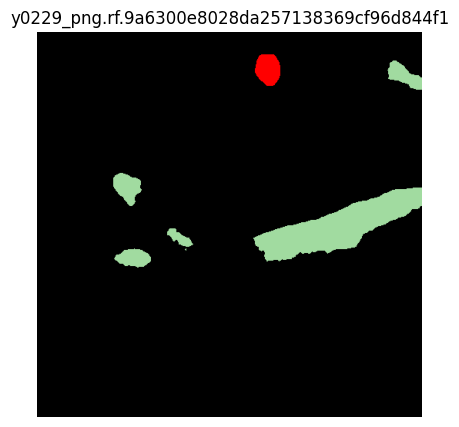

Excluding y0230_png.rf.173af80840a6809e2271169dc254e0f1 for class 2


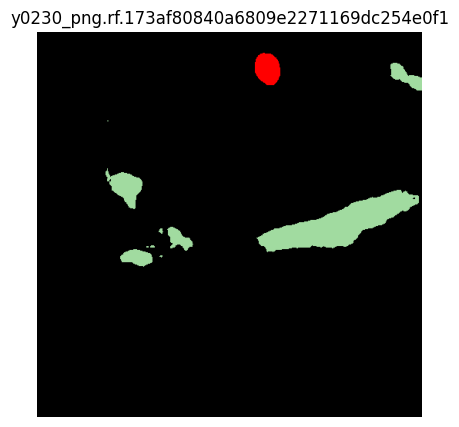

Excluding y0231_png.rf.7516089a2c46f834b6b1e2d7645682c2 for class 2


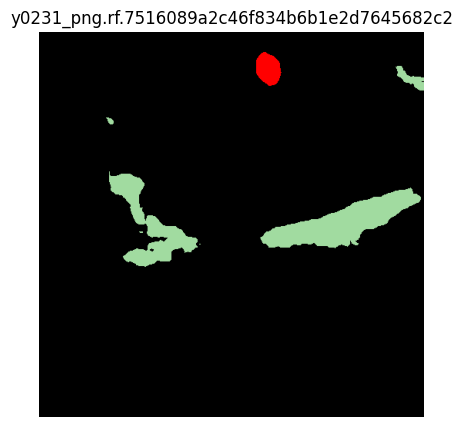

Excluding y0232_png.rf.f2f643e78e9ba002136c3afff6b9298a for class 2


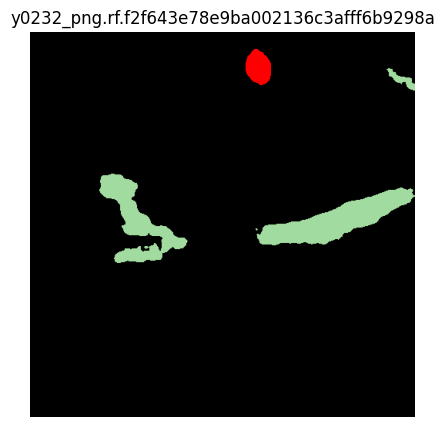

Excluding y0233_png.rf.61f84737ec95d578fdfd87babae598db for class 2


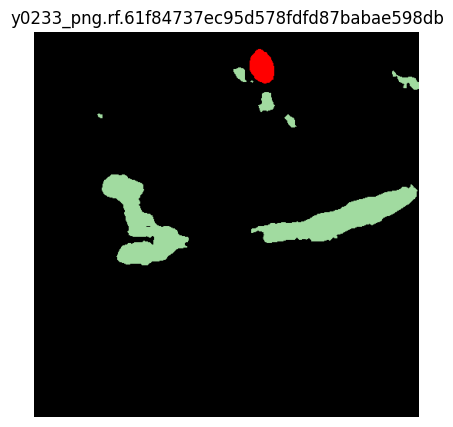

Excluding y0234_png.rf.264b147afba1bda326258a6c186d148f for class 2


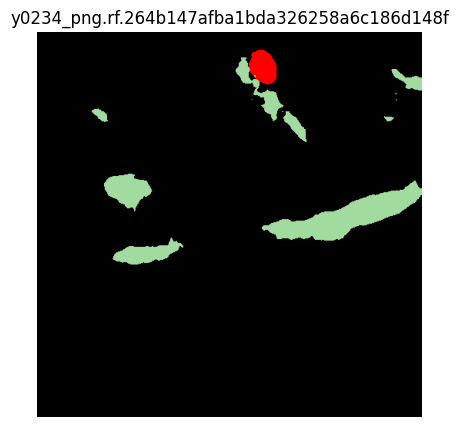

Excluding y0235_png.rf.46a8f25e5a96b20244fab2b88ad11d36 for class 2


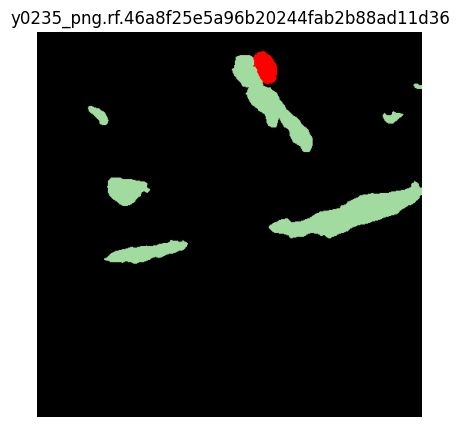

Excluding y0236_png.rf.83d46aa0b5e05e55058ffcb202c79969 for class 2


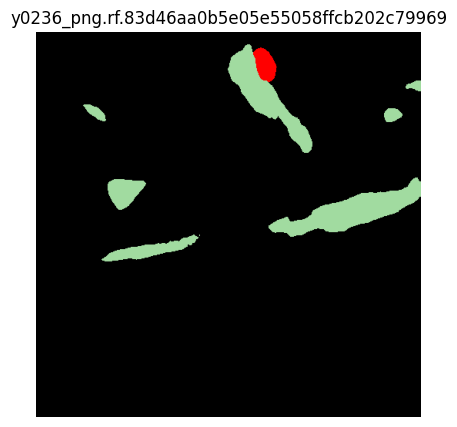

Excluding y0237_png.rf.ec86d173671469356b9ccd55ba218a9e for class 2


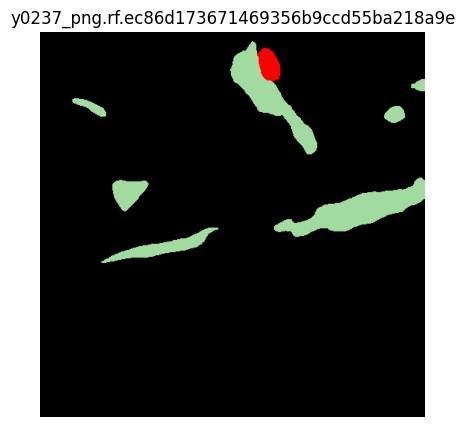

Excluding y0238_png.rf.60de6f9c58ff81236a85977aac023145 for class 2


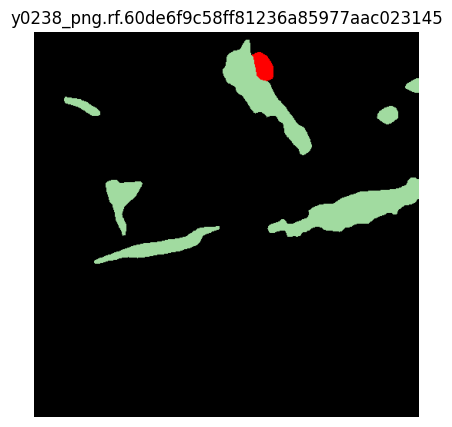

Excluding y0239_png.rf.a7c8f288b480b398b7878f69cc3baf05 for class 2


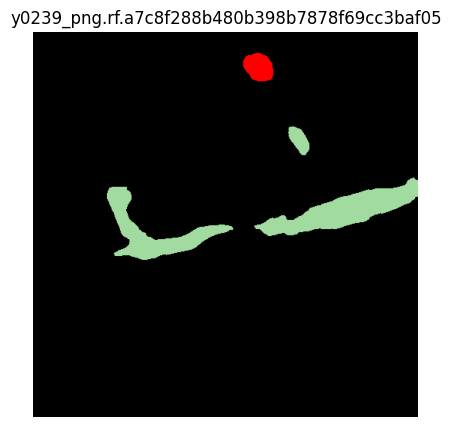

Excluding y0240_png.rf.4819f22b4c87be838343eb6a59ab4f3d for class 2


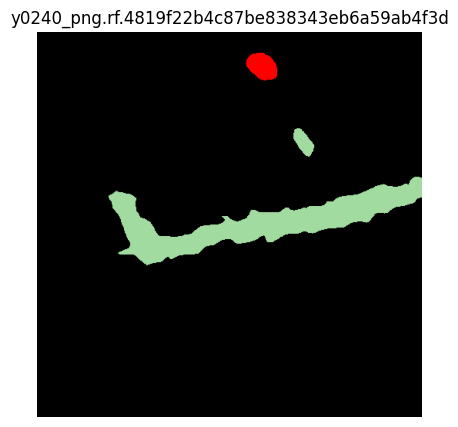

In [ ]:
# @title Combine class masks

from collections import defaultdict

def get_file_map(directory):
    file_map = defaultdict(list)
    for fname in os.listdir(directory):
        name, ext = os.path.splitext(fname)
        file_map[name].append(os.path.join(directory, fname))
    return file_map

def combine_class_masks(mask_dirs, exclude_ranges=None, output_dir=None, show=True):
    os.makedirs(output_dir, exist_ok=True) if output_dir else None
    mask_maps = []

    for i in range(len(mask_dirs)):
        mask_maps.append(get_file_map(mask_dirs[i]))

    shared_keys = set(mask_maps[0].keys())
    for d in mask_maps[1:]:
        shared_keys.intersection_update(d.keys())
    shared_keys = sorted(shared_keys)

    for base_name in shared_keys:
        masks = []
        bins = []
        # Extract number part from filename (assumes 'y####_png...')
        try:
            number = int(base_name[1:5])
        except ValueError:
            print(f"Skipping invalid file name: {base_name}")
            continue

        for i in range(len(mask_dirs)):
            exclude = False
            start, end = exclude_ranges[i]
            if start != "none" and end != "none":
                if int(start) <= number <= int(end):
                    exclude = True

            if exclude:
                print(f"Excluding {base_name} for class {i}")
                # Create empty mask
                file_path = next(iter(mask_maps[i].values()))[0]
                empty_mask = np.zeros_like(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE))
                masks.append(empty_mask)
            else:
                masks.append(cv2.imread(mask_maps[i][base_name][0], cv2.IMREAD_GRAYSCALE))

        for i in range(len(masks)):
            # Binarize masks
            bins.append((masks[i] > 0).astype(np.uint8))

        # Resolve conflicts: first class takes priority
        for i in range(len(bins)-1, 0, -1):
            bins[i][bins[i-1] == 1] = 0

        # Create RGB mask
        rgb_mask = np.zeros((*bins[0].shape, 3), dtype=np.uint8)
        rgb_mask[:, :, 0] = bins[1] * 255  # Red

        lnf_mask = bins[0] == 1
        rgb_mask[lnf_mask, 0] = 161  # Green
        rgb_mask[lnf_mask, 1] = 219
        rgb_mask[lnf_mask, 2] = 160

        tumor_mask = bins[2] == 1
        rgb_mask[tumor_mask, 0] = 255
        rgb_mask[tumor_mask, 1] = 215
        rgb_mask[tumor_mask, 2] = 0

        if output_dir:
            out_path = os.path.join(output_dir, base_name + '.png')
            cv2.imwrite(out_path, cv2.cvtColor(rgb_mask, cv2.COLOR_RGB2BGR))

        if show:
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb_mask)
            plt.title(base_name)
            plt.axis('off')
            plt.show()



mask_dir_bv = 'vol1_2-2/merged_predictions_bv_2'  # will appear red
mask_dir_lnf = 'vol1_2-2/merged_predictions_lnf'  # will appear green
mask_dir_roi = 'vol1_2-2/merged_predictions_roi'
output_dir = '/content/final_merged'

combine_class_masks([mask_dir_lnf, mask_dir_bv, mask_dir_roi], [["none","none"], ["0064", "0068"], ["0178","0240"]], output_dir=output_dir, show=True)


In [ ]:
import shutil
from google.colab import files

# Set the path of the folder you want to download
folder_path = '/content/final_merged'  # change this to your folder path
zip_path = "/content/final_merged.zip"

# Zip the folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

# Download the zip file
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>